# Introduction

We provide an evaluation pipeline to analyze results on **lmgame-Bench**. 🎮

- **Code:** <https://github.com/lmgame-org/GamingAgent>  
- **Leaderboard:** <https://huggingface.co/spaces/lmgame/game_arena_bench>  
- **Paper:** <https://arxiv.org/abs/2505.15146>

You can evaluate your model in on run 📊:
General two-step workflow: 
1. Run benchmark result: Enter the github repo: <https://github.com/lmgame-org/GamingAgent>  and run one line code to run through games and generate a cache directory under the home directory
``
[placehodler one line running script]
``
1. **Entire cache directory:** Submit the entire cache directory or cache zip file containing all cached episodes to obtain aggregate performance across all games  in colab local directory.

run benchmark;
download cache directory sample 
intruction heavy

## Data Preparation
1. Extract local data
2. Load online benchmark data
3. Update local benchmark data with local data 

In [1]:
import os
import glob
import zipfile 
import requests
import json
import pandas as pd
import shutil


# Default Constants: our online benchmark data, model colors, other benchmark ranks, polynomial model results_save_path
MODEL_PERF_RANK_URL = "https://raw.githubusercontent.com/lmgame-org/GamingAgent/refs/heads/codebase_refactor_eval_dev/eval/perf/model_perf_rank.json"
MODEL_COLORS_URL = "https://raw.githubusercontent.com/lmgame-org/GamingAgent/refs/heads/codebase_refactor_eval_dev/eval/assets/model_colors.json"
OTHER_TASK_RANK_URL = "https://raw.githubusercontent.com/lmgame-org/GamingAgent/codebase_refactor_eval_dev/eval/perf/other_task_rank.json"
POLYNOMIAL_MODEL_RESULTS_JSON_PATH = "polynomial_model_results.json"

In [2]:
### Extract local data
def check_evaluation_files(cache_dir_status):
    report = {}

    if cache_dir_status:
        cache_dir_path_to_check = "cache"
        cache_zip_file_to_check = "cache.zip"

        if os.path.isdir(cache_dir_path_to_check):
            report["cache_directory"] = cache_dir_path_to_check
            print(f"Using existing cache directory: '{cache_dir_path_to_check}'")
        elif os.path.isfile(cache_zip_file_to_check):
            print(f"Found cache zip file: '{cache_zip_file_to_check}'. Attempting to unzip.")

            # Prepare for unzipping: remove existing 'cache' directory if it's a directory
            if os.path.isdir(cache_dir_path_to_check):
                print(f"Removing existing directory '{cache_dir_path_to_check}' before unzipping.")
                try:
                    shutil.rmtree(cache_dir_path_to_check)
                except OSError as e:
                    print(f"Error removing directory {cache_dir_path_to_check}: {e}")
                    report["cache_directory"] = None
                    return report # Exit if we can't prepare the directory
            try:
                with zipfile.ZipFile(cache_zip_file_to_check, 'r') as zip_ref:
                    zip_ref.extractall(cache_dir_path_to_check)
                if os.path.isdir(cache_dir_path_to_check):
                    report["cache_directory"] = cache_dir_path_to_check
                    print(f"Successfully unzipped '{cache_zip_file_to_check}' to '{cache_dir_path_to_check}' using Python's zipfile module.")
                else:
                    print(f"Error: Failed to unzip '{cache_zip_file_to_check}' or directory not found after unzipping (using Python's zipfile).")
                    report["cache_directory"] = None
            except zipfile.BadZipFile:
                print(f"Error: '{cache_zip_file_to_check}' is not a valid zip file or is corrupted.")
                report["cache_directory"] = None
            except Exception as e:
                print(f"An error occurred during unzipping with Python's zipfile: {e}")
                report["cache_directory"] = None

        else:
            report["cache_directory"] = None
            print(f"Error: Cache directory '{cache_dir_path_to_check}' or cache file '{cache_zip_file_to_check}' not found.")
    else: # If cache_dir_status is False
        report["cache_directory"] = None
        print("Info: Cache directory status is False. No cache will be checked.")

    return report


def generate_evaluation_map(file_info, cache_dir_status): # Removed single_json_status
    """
    Generates a map from agent_config.json paths to a list of corresponding episode_*.jsonl paths,
    handling nested subdirectories in cache. Now only processes cache.

    Args:
        file_info (dict): The report from check_evaluation_files.
        cache_dir_status (bool): Flag indicating if cache directory/zip processing is enabled.

    Returns:
        dict: A map where keys are paths to agent_config.json files and
              values are lists of paths to corresponding episode_*.jsonl files.
    """
    run_map = {}

    if cache_dir_status and file_info.get("cache_directory"):
        cache_location = file_info["cache_directory"]
        print(f"Info: Attempting to generate map from cache location: {cache_location}")

        if os.path.isdir(cache_location):
            print(f"Info: Processing cache directory: {cache_location}")
            for dirpath, dirnames, filenames in os.walk(cache_location):
                if "agent_config.json" in filenames:
                    current_agent_config = os.path.join(dirpath, "agent_config.json")
                    episode_log_pattern = os.path.join(dirpath, "episode_*.jsonl")
                    episode_logs = sorted(glob.glob(episode_log_pattern))
                    
                    if episode_logs:
                        run_map[current_agent_config] = episode_logs
                        print(f"  Mapped in dir '{dirpath}': '{current_agent_config}' to {len(episode_logs)} log(s)")
        
        elif os.path.isfile(cache_location) and cache_location.endswith(".zip"):
            print(f"Info: Processing cache zip file: {cache_location}")
            files_by_internal_dir = {}
            try:
                with zipfile.ZipFile(cache_location, 'r') as zip_f:
                    for item_name_in_zip in zip_f.namelist():
                        normalized_item_path = item_name_in_zip.replace('\\\\', '/')
                        if normalized_item_path.endswith('/'): 
                            continue

                        internal_dir_path = os.path.dirname(normalized_item_path)
                        internal_filename = os.path.basename(normalized_item_path)
                        
                        if internal_dir_path not in files_by_internal_dir:
                            files_by_internal_dir[internal_dir_path] = []
                        files_by_internal_dir[internal_dir_path].append(internal_filename)
                
                for internal_dir, filenames_in_dir in files_by_internal_dir.items():
                    if "agent_config.json" in filenames_in_dir:
                        agent_config_zip_path = f"{internal_dir}/agent_config.json" if internal_dir else "agent_config.json"
                        episode_logs_zip_paths = []
                        for fname in filenames_in_dir:
                            if fname.startswith("episode_") and fname.endswith(".jsonl"):
                                log_path_in_zip = f"{internal_dir}/{fname}" if internal_dir else fname
                                episode_logs_zip_paths.append(log_path_in_zip)
                        
                        if episode_logs_zip_paths:
                            run_map[agent_config_zip_path] = sorted(episode_logs_zip_paths)
                            print(f"  Mapped in zip (dir '{internal_dir}'): '{agent_config_zip_path}' to {len(episode_logs_zip_paths)} log(s)")

            except zipfile.BadZipFile:
                print(f"Error: Could not read zip file {cache_location}. It may be corrupted.")
            except Exception as e:
                print(f"An error occurred while processing zip file {cache_location}: {e}")
        
        if run_map:
             print(f"Info: Map generation from cache completed.")
        else:
            print(f"Warning: Cache processing was enabled for '{cache_location}', but no valid agent_config to episode_log mappings were found.")
    elif cache_dir_status and not file_info.get("cache_directory"):
        print("Info: Cache processing was enabled, but no cache directory or file was found by check_evaluation_files.")
    elif not cache_dir_status:
        print("Info: Cache processing is disabled. No map will be generated from cache.")


    if not run_map:
        print("Warning: No evaluation map could be generated with the current settings and files.")
        
    return run_map


# Extract results from evaluation run map
def _try_parse_json_string_for_function(value, field_name_for_error, log_file_basename, line_num_str):
    """
    Helper to parse a field that might be a JSON string.
    Used by the process_evaluation_run_map function.
    """
    if isinstance(value, str):
        try:
            return json.loads(value)
        except json.JSONDecodeError:
            return value # Return original string if parsing fails
    return value # Return as is if not a string

def process_evaluation_run_map(evaluation_run_map):
    """
    Processes an evaluation_run_map to extract and structure data from
    agent_config.json and episode_*.jsonl files.

    Args:
        evaluation_run_map (dict): A map where keys are paths to agent_config.json
                                   files and values are lists of paths to
                                   corresponding episode_*.jsonl files.

    Returns:
        dict: A dictionary where keys are tuples (game_name, model_name,
              observation_mode, harness_bool) and values are lists of
              dictionaries, each representing a processed episode.
              Each episode dictionary contains:
              'episode_id', 'total_steps', 'total_reward',
              'total_perf_score', 'total_time_taken',
              'agent_observations' (list), 'infos' (list).
    """
    grouped_results = {}

    if not evaluation_run_map:
        print("Warning: The provided evaluation_run_map is empty. No processing will occur.")
        return grouped_results

    for agent_config_filepath, episode_log_filepaths in evaluation_run_map.items():
        # 1. Read and parse agent_config.json
        game_name = None
        model_name = None
        observation_mode = None
        harness_bool = None # Store harness as boolean

        if not os.path.isfile(agent_config_filepath):
            print(f"Error: Agent config file not found at '{agent_config_filepath}'. Skipping associated logs.")
            continue
        
        try:
            with open(agent_config_filepath, 'r') as f_agent_config:
                agent_config_data = json.load(f_agent_config)
            
            game_name = agent_config_data.get("game_name")
            model_name = agent_config_data.get("model_name")
            observation_mode = agent_config_data.get("observation_mode")
            harness_bool = agent_config_data.get("harness") # This should ideally be boolean (True/False)
            
            if harness_bool is None: # Handle if 'harness' key is missing
                print(f"Warning: 'harness' key missing in {agent_config_filepath}. Assuming False.")
                harness_bool = False

        except json.JSONDecodeError:
            print(f"Error: Could not decode JSON from agent config: '{agent_config_filepath}'. Skipping.")
            continue
        except Exception as e:
            print(f"Error reading agent config '{agent_config_filepath}': {e}. Skipping.")
            continue

        # Create the grouping key
        # Ensure all parts of the key are actual values to avoid issues with None in dict keys
        if game_name is None or model_name is None or observation_mode is None:
            print(f"Warning: Missing one or more key identifiers (game_name, model_name, observation_mode) in '{agent_config_filepath}'. Skipping this config and its logs.")
            continue
            
        group_key = (game_name, model_name, observation_mode, harness_bool)

        if group_key not in grouped_results:
            grouped_results[group_key] = []

        # 2. Process corresponding episode logs
        if not episode_log_filepaths:
            print(f"Info: No episode logs listed for agent config: '{agent_config_filepath}'.")
            continue

        for episode_log_path in episode_log_filepaths:
            if not os.path.isfile(episode_log_path):
                print(f"Warning: Episode log file not found: '{episode_log_path}'. Skipping.")
                continue

            log_basename = os.path.basename(episode_log_path)
            try:
                episode_id_str = log_basename.replace("episode_", "").replace("_log.jsonl", "")
            except Exception:
                episode_id_str = log_basename # Fallback

            ep_total_steps = 0
            ep_total_reward = 0
            ep_total_perf_score = 0.0
            ep_infos_list = []
            ep_agent_observations_list = []
            
            episode_lines_data = []
            sum_step_time_taken_s = 0.0
            found_step_time_taken_s_in_episode = False
            final_total_time_taken_from_last_step_info = None

            try:
                with open(episode_log_path, 'r') as f_episode_log:
                    for line_num, line in enumerate(f_episode_log):
                        try:
                            step_data = json.loads(line)
                            episode_lines_data.append(step_data)
                        except json.JSONDecodeError:
                            # print(f"Warning: Could not decode JSON from line {line_num + 1} in '{log_basename}'. Skipping line.")
                            continue
                
                if not episode_lines_data:
                    # print(f"Warning: No valid JSON lines found in '{log_basename}'. Skipping this log.")
                    continue

                ep_total_steps = len(episode_lines_data)

                for step_idx, step_data_dict in enumerate(episode_lines_data):
                    ep_total_reward += step_data_dict.get("reward", 0)
                    ep_total_perf_score += step_data_dict.get("perf_score", 0.0)
                    
                    raw_obs = step_data_dict.get("agent_observation")
                    parsed_obs = _try_parse_json_string_for_function(raw_obs, "agent_observation", log_basename, str(step_idx+1))
                    ep_agent_observations_list.append(parsed_obs)

                    raw_info = step_data_dict.get("info")
                    parsed_info = _try_parse_json_string_for_function(raw_info, "info", log_basename, str(step_idx+1))
                    ep_infos_list.append(parsed_info)

                    if "time_taken_s" in step_data_dict:
                        try:
                            sum_step_time_taken_s += float(step_data_dict["time_taken_s"])
                            found_step_time_taken_s_in_episode = True
                        except (ValueError, TypeError):
                            pass 

                    if step_idx == ep_total_steps - 1: # Last step
                        if isinstance(parsed_info, dict) and "total_time_taken" in parsed_info:
                            try:
                                final_total_time_taken_from_last_step_info = float(parsed_info["total_time_taken"])
                            except (ValueError, TypeError):
                                pass # Keep it None if not a valid float

                ep_total_time_taken = None
                if final_total_time_taken_from_last_step_info is not None:
                    ep_total_time_taken = final_total_time_taken_from_last_step_info
                elif found_step_time_taken_s_in_episode:
                    ep_total_time_taken = sum_step_time_taken_s
                
                episode_data_point = {
                    "episode_id": episode_id_str,
                    "total_steps": ep_total_steps,
                    "total_reward": ep_total_reward,
                    "total_perf_score": ep_total_perf_score,
                    "total_time_taken": ep_total_time_taken,
                    "agent_observations": ep_agent_observations_list,
                    "infos": ep_infos_list
                }
                grouped_results[group_key].append(episode_data_point)

            except Exception as e:
                print(f"Error processing episode log '{episode_log_path}': {e}")
                continue # Skip to next episode log file
                
    return grouped_results

def calculate_average_performance(extracted_results_map):
    """
    Calculates average performance metrics from the extracted_results_map.

    Args:
        extracted_results_map (dict): The output from process_evaluation_run_map,
                                      where keys are tuples (game_name, model_name,
                                      observation_mode, harness_bool) and values are
                                      lists of episode data dictionaries.

    Returns:
        list: A list of dictionaries, where each dictionary represents a group
              and its averaged 'total_steps', 'total_reward', 'total_perf_score',
              along with the group identifiers and 'num_episodes'.
    """
    averaged_data_list = []

    if not extracted_results_map:
        print("Warning: The provided extracted_results_map is empty. No averages will be calculated.")
        return averaged_data_list

    for group_key, episodes_list in extracted_results_map.items():
        game_name, model_name, observation_mode, harness = group_key
        
        if not episodes_list:
            print(f"Info: No episodes found for group: {group_key}. Skipping averaging for this group.")
            # Optionally, you could add an entry with 0 episodes and NaN/0 averages
            averaged_data_list.append({
                "game_name": game_name,
                "model_name": model_name,
                "observation_mode": observation_mode,
                "harness": harness,
                "num_episodes": 0,
                "avg_total_steps": 0, # or float('nan')
                "avg_total_reward": 0, # or float('nan')
                "avg_total_perf_score": 0, # or float('nan')
                "avg_total_time_taken": 0 # or float('nan')
            })
            continue

        num_episodes = len(episodes_list)
        sum_steps = 0
        sum_reward = 0
        sum_perf_score = 0
        sum_time_taken = 0
        episodes_with_time = 0


        for episode_data in episodes_list:
            sum_steps += episode_data.get("total_steps", 0)
            sum_reward += episode_data.get("total_reward", 0)
            sum_perf_score += episode_data.get("total_perf_score", 0.0)
            
            time_taken = episode_data.get("total_time_taken")
            if time_taken is not None:
                sum_time_taken += time_taken
                episodes_with_time += 1
        
        avg_steps = sum_steps / num_episodes if num_episodes > 0 else 0
        avg_reward = sum_reward / num_episodes if num_episodes > 0 else 0
        avg_perf_score = sum_perf_score / num_episodes if num_episodes > 0 else 0
        avg_time_taken = sum_time_taken / episodes_with_time if episodes_with_time > 0 else None


        averaged_data_list.append({
            "game_name": game_name,
            "model_name": model_name,
            "observation_mode": observation_mode,
            "harness": harness, # This is already boolean from the group_key
            "num_episodes": num_episodes,
            "avg_total_steps": avg_steps,
            "avg_total_reward": avg_reward,
            "avg_total_perf_score": avg_perf_score,
            "avg_total_time_taken": avg_time_taken
        })
        
    return averaged_data_list



# --- Example Usage ---
# Now, you only need to decide if you want to use cache processing or not.
# The single_json_processing flag is no longer used by the functions.
use_cache_dir_processing = True 

print("--- Step 1: Checking evaluation files ---")
# Call check_evaluation_files without single_json_status argument
initial_file_report = check_evaluation_files(use_cache_dir_processing)

print("\n--- Step 2: Generating evaluation map ---")
# Call generate_evaluation_map without single_json_status argument
evaluation_run_map = generate_evaluation_map(initial_file_report, use_cache_dir_processing)

print("\n--- Step 3: Extracting results from evaluation map ---")

extracted_results = process_evaluation_run_map(evaluation_run_map=evaluation_run_map)

print("\n--- Step 4: Generating averaged results ---")
averaged_results = calculate_average_performance(extracted_results)

print("\n--- Averaged Results ---")
for result in averaged_results:
    print(f"Game: {result['game_name']}, Model: {result['model_name']}, Observation Mode: {result['observation_mode']}, Harness: {result['harness']}")
    print(f"  Number of Episodes: {result['num_episodes']}")
    print(f"  Average Total Steps: {result['avg_total_steps']}")
    print(f"  Average Total Reward: {result['avg_total_reward']}")
    print(f"  Average Total Perf Score: {result['avg_total_perf_score']}")
    print(f"  Average Total Time Taken: {result['avg_total_time_taken']}")
    print("\n")

--- Step 1: Checking evaluation files ---
Error: Cache directory 'cache' or cache file 'cache.zip' not found.

--- Step 2: Generating evaluation map ---
Info: Cache processing was enabled, but no cache directory or file was found by check_evaluation_files.

--- Step 3: Extracting results from evaluation map ---

--- Step 4: Generating averaged results ---

--- Averaged Results ---


In [3]:
### Load online benchmark data and update benchmark data with local data
def convert_local_averages_to_dataframe(local_averaged_results_list: list) -> pd.DataFrame:
    """
    Converts a list of local averaged results (dictionaries) into a Pandas DataFrame
    with columns 'model_name', 'harness', 'game_name', and 'avg_score_from_rank'.
    The 'avg_score_from_rank' column is populated from the 'avg_total_perf_score'
    field of the input dictionaries.
    """
    if not local_averaged_results_list:
        print("Warning: The local_averaged_results_list is empty. Returning an empty DataFrame.")
        return pd.DataFrame(columns=['model_name', 'harness', 'game_name', 'avg_score_from_rank'])

    # Create a list of dictionaries with only the desired columns and new key name
    formatted_list_for_df = []
    for item in local_averaged_results_list:
        if not isinstance(item, dict):
            print(f"Warning: Skipping an item in local_averaged_results_list as it's not a dictionary: {item}")
            continue
        
        # Ensure all necessary keys are present in the item before trying to access them
        required_keys = ['model_name', 'harness', 'game_name', 'avg_total_perf_score']
        if not all(key in item for key in required_keys):
            print(f"Warning: Skipping an item due to missing one or more required keys ({', '.join(required_keys)}): {item}")
            continue
            
        formatted_list_for_df.append({
            "model_name": item['model_name'],
            "harness": item['harness'],  # Assuming this is already boolean
            "game_name": item['game_name'],
            "avg_score_from_rank": item['avg_total_perf_score'] # Mapping local score to this new column name
        })
    
    if not formatted_list_for_df:
        print("Warning: No valid data could be extracted from local_averaged_results_list. Returning an empty DataFrame.")
        return pd.DataFrame(columns=['model_name', 'harness', 'game_name', 'avg_score_from_rank'])

    df_local_formatted = pd.DataFrame(formatted_list_for_df)
    print(f"Created DataFrame from local averaged results with {len(df_local_formatted)} rows and columns: {list(df_local_formatted.columns)}")
    return df_local_formatted

def load_and_average_benchmark_rank_data(url: str) -> pd.DataFrame:
    """
    Fetches benchmark rank data from a URL, calculates average scores,
    and returns it as a Pandas DataFrame.
    The 'harness' column in the output DataFrame will be boolean.
    'avg_score_from_rank' is the column with the calculated average from the benchmark file.
    """
    benchmark_rank_data_dict = {}
    print(f"Attempting to download benchmark data from: {url}")
    try:
        response = requests.get(url)
        response.raise_for_status()  # Raise an HTTPError for bad responses (4xx or 5xx)
        benchmark_rank_data_dict = response.json() # requests can directly parse to dict
        print("Benchmark data successfully downloaded and parsed.")
    except requests.exceptions.RequestException as e:
        print(f"Error: Could not download data from {url}. Exception: {e}")
        return pd.DataFrame() # Return empty DataFrame on error
    except json.JSONDecodeError as e: # response.json() can also raise this if content is not valid JSON
        print(f"Error: Could not parse JSON from the URL response. Exception: {e}")
        return pd.DataFrame() # Return empty DataFrame on error
    except Exception as e: # Catch any other unexpected errors
        print(f"An unexpected error occurred while fetching or loading benchmark data: {e}")
        return pd.DataFrame()

    # Calculate averages
    rank_averages_list_of_dicts = []
    if not benchmark_rank_data_dict:
        print("Warning: Empty benchmark_rank_data_dict received. Cannot calculate averages from it.")
        return pd.DataFrame()

    for model_name, harness_data in benchmark_rank_data_dict.items():
        if not isinstance(harness_data, dict):
            # print(f"Skipping model '{model_name}' in benchmark data: harness_data is not a dict.")
            continue
        for harness_status_str, game_data in harness_data.items():
            if not isinstance(game_data, dict):
                # print(f"Skipping harness '{harness_status_str}' for model '{model_name}': game_data is not a dict.")
                continue
            
            # Convert harness status string to boolean for consistent merging
            harness_bool = True if harness_status_str == "harness_true" else False
            
            for game_name, scores_list in game_data.items():
                avg_score = pd.NA # Use pd.NA for missing numeric data
                if scores_list and isinstance(scores_list, list):
                    # Filter out non-numeric scores before averaging
                    numeric_scores = [s for s in scores_list if isinstance(s, (int, float))]
                    if numeric_scores: # Ensure there's at least one numeric score
                        avg_score = sum(numeric_scores) / len(numeric_scores)
                    # else:
                        # print(f"No numeric scores found for {model_name}/{harness_status_str}/{game_name} in benchmark.")
                # else:
                    # print(f"Scores_list is empty or not a list for {model_name}/{harness_status_str}/{game_name} in benchmark.")
                    
                rank_averages_list_of_dicts.append({
                    "model_name": model_name,
                    "harness": harness_bool, 
                    "game_name": game_name,
                    "avg_score_from_rank": avg_score  # This will be the averaged score from the rank file
                })
    
    if not rank_averages_list_of_dicts:
        print("No averages could be calculated from the benchmark rank data (list is empty).")
        return pd.DataFrame()
        
    df_benchmark_avg = pd.DataFrame(rank_averages_list_of_dicts)
    print(f"Created DataFrame from benchmark rank averages with {len(df_benchmark_avg)} rows.")
    return df_benchmark_avg

def combine_and_update_averages(df_benchmark: pd.DataFrame, df_local_updates: pd.DataFrame) -> pd.DataFrame:
    """
    Combines benchmark averages with local update averages.
    Local updates will override benchmark data for the same (model_name, harness, game_name) keys.
    All unique entries from both DataFrames will be included.

    Args:
        df_benchmark: DataFrame with columns ['model_name', 'harness', 'game_name', 'avg_score_from_rank']
                      from the benchmark data.
        df_local_updates: DataFrame with columns ['model_name', 'harness', 'game_name', 'avg_score_from_rank']
                          from the local averaged data (where 'avg_score_from_rank' holds local scores).

    Returns:
        A Pandas DataFrame with the combined and updated averages.
    """
    if df_local_updates.empty and df_benchmark.empty:
        print("Both benchmark and local update DataFrames are empty. Returning an empty DataFrame.")
        return pd.DataFrame(columns=['model_name', 'harness', 'game_name', 'avg_score_from_rank'])

    if df_local_updates.empty:
        print("Local updates DataFrame is empty. Returning benchmark DataFrame as is.")
        return df_benchmark.copy() # Return a copy to avoid modifying the original

    if df_benchmark.empty:
        print("Benchmark DataFrame is empty. Returning local updates DataFrame as is.")
        return df_local_updates.copy()

    # Set the multi-index for both DataFrames to easily update and combine
    keys = ['model_name', 'harness', 'game_name']
    
    # Ensure keys are present in both dataframes
    for key_col in keys:
        if key_col not in df_benchmark.columns:
            print(f"Warning: Key column '{key_col}' not found in benchmark DataFrame. Returning local updates.")
            return df_local_updates.copy()
        if key_col not in df_local_updates.columns:
            print(f"Warning: Key column '{key_col}' not found in local updates DataFrame. Returning benchmark data.")
            return df_benchmark.copy()
            
    df_benchmark_indexed = df_benchmark.set_index(keys)
    df_local_updates_indexed = df_local_updates.set_index(keys)

    # Update the benchmark data with local data.
    # Rows in local_updates will overwrite rows in benchmark_indexed if the index matches.
    # Rows in local_updates not in benchmark_indexed will be added.
    df_combined_indexed = df_benchmark_indexed.copy() # Start with a copy of benchmark
    df_combined_indexed.update(df_local_updates_indexed) # Update with local, overwrites existing, does not add new from local

    # Add new rows from local_updates_indexed that were not in df_benchmark_indexed
    # This requires finding rows in local that are not in benchmark and concatenating.
    # A more straightforward way for 'outer join' like behavior with local priority is:
    
    # Re-think: A simpler approach for "local overrides, then add unique from benchmark"
    # 1. Take all local data.
    # 2. Find benchmark data that is NOT in local (based on keys) and append it.

    # Set index on local updates
    df_local_final = df_local_updates.set_index(keys)

    # Filter benchmark data to get only rows NOT present in local updates
    # This uses the index of df_local_final to exclude matching rows from df_benchmark
    df_benchmark_only = df_benchmark.set_index(keys)[~df_benchmark.set_index(keys).index.isin(df_local_final.index)]
    
    # Concatenate local data (which has priority) with the unique benchmark data
    df_final_combined = pd.concat([df_local_final, df_benchmark_only])
    
    # Reset index to get 'model_name', 'harness', 'game_name' back as columns
    df_final_combined = df_final_combined.reset_index()

    print(f"Combined DataFrame created. Local updates took priority. Final rows: {len(df_final_combined)}")
    return df_final_combined

# --- Example of how to call this function ---
# You can run this in your notebook cell to see the output of this first step:
update_model_averages = convert_local_averages_to_dataframe(averaged_results)
df_benchmark_averages = load_and_average_benchmark_rank_data(MODEL_PERF_RANK_URL)
final_updated_df = combine_and_update_averages(df_benchmark_averages, update_model_averages)
final_updated_df


Attempting to download benchmark data from: https://raw.githubusercontent.com/lmgame-org/GamingAgent/refs/heads/codebase_refactor_eval_dev/eval/perf/model_perf_rank.json
Benchmark data successfully downloaded and parsed.
Created DataFrame from benchmark rank averages with 158 rows.
Local updates DataFrame is empty. Returning benchmark DataFrame as is.


,model_name,harness,game_name,avg_score_from_rank
0,claude-3-5-sonnet-20241022,True,sokoban,0.0
1,claude-3-5-sonnet-20241022,True,super_mario_bros,1267.666667
2,claude-3-5-sonnet-20241022,True,tetris,14.666667
3,claude-3-5-sonnet-20241022,True,twenty_forty_eight,21.642586
4,claude-3-5-sonnet-20241022,True,candy_crush,106.0
...,...,...,...,...
153,o4-mini-2025-04-16,False,twenty_forty_eight,19.511276
154,o4-mini-2025-04-16,False,candy_crush,110.666667
155,o4-mini-2025-04-16,False,ace_attorney,2.0
156,claude-3-haiku-20240307,False,twenty_forty_eight,27.69098


### Game Performance Visualization
1. Radar Chart
2. Group Bar Chart

In [4]:
# Default model and game names
show_games = list(final_updated_df['game_name'].unique())
show_models = list(final_updated_df['model_name'].unique())

highlight_models = []
if 'average_results' in locals() and average_results is not None:
    highlight_models = list(average_results['model_name'].unique())

highlight_models = ['claude-3-5-sonnet-20241022']

import plotly.graph_objects as go
import numpy as np
import pandas as pd
import json
import requests
import random
from typing import Dict, List, Optional

# Model colors configuration
MODEL_COLORS_URL = "https://raw.githubusercontent.com/your-repo/model_colors.json"  # Replace with actual URL
model_colors_for_plots = {}
used_colors_from_json = set()

def normalize_column_safely(column_series):
    numeric_series = pd.to_numeric(column_series, errors='coerce')
    min_val = numeric_series.min()
    max_val = numeric_series.max()

    if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val:
        result_series = pd.Series([pd.NA] * len(numeric_series), index=numeric_series.index, dtype=float)
        valid_numeric_mask = numeric_series.notna()
        result_series[valid_numeric_mask] = 1.0 # Default to 1 if no range or all same
        return result_series
    else:
        return (numeric_series - min_val) / (max_val - min_val) * 99 + 1

def hex_to_rgba(hex_color, alpha=0.2):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

def get_random_color(existing_colors_hex: set) -> str:
    """Generates a random hex color string, trying to avoid existing ones."""
    attempts = 0
    while attempts < 100:
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        hex_color = f'#{r:02x}{g:02x}{b:02x}'
        if hex_color not in existing_colors_hex:
            return hex_color
        attempts += 1
    return f'#{random.randint(0,255):02x}{random.randint(0,255):02x}{random.randint(0,255):02x}'

# Load model colors
print(f"Attempting to load model colors from URL...")
try:
    response = requests.get(MODEL_COLORS_URL)
    response.raise_for_status()
    model_colors_from_url = response.json()
    model_colors_for_plots.update(model_colors_from_url)
    used_colors_from_json.update(model_colors_from_url.values())
    print(f"Successfully loaded model colors from URL. {len(model_colors_for_plots)} colors loaded.")
except:
    print("Warning: Could not download model colors. Will use random colors for all models.")

def prepare_dataframe_for_plots(source_df: pd.DataFrame, selected_games: List[str], selected_models: List[str], harness_bool_to_use: bool) -> pd.DataFrame:
    if source_df.empty:
        print("Input source_df is empty. Cannot prepare for plots.")
        return pd.DataFrame()
    
    # Filter by harness, games, and models
    df_filtered = source_df[
        (source_df['harness'] == harness_bool_to_use) & 
        (source_df['game_name'].isin(selected_games)) &
        (source_df['model_name'].isin(selected_models))
    ].copy()
    
    if df_filtered.empty:
        print(f"Warning: No data found for harness={harness_bool_to_use}, selected games and models.")
        return pd.DataFrame()
    
    # Pivot the data
    try:
        df_pivot = df_filtered.pivot_table(
            index='model_name', columns='game_name', values='avg_score_from_rank'
        ).reset_index().rename(columns={'model_name': 'Player'})
    except Exception as e:
        print(f"Error during pivoting: {e}")
        return pd.DataFrame()
    
    if df_pivot.empty:
        print(f"Pivoted DataFrame is empty for harness={harness_bool_to_use}.")
        return pd.DataFrame()
    
    # Normalize each game column using the provided function
    for game_name in selected_games:
        if game_name in df_pivot.columns:
            df_pivot[game_name] = normalize_column_safely(df_pivot[game_name])
    
    return df_pivot

def create_comparison_radar_chart(df: pd.DataFrame, model_colors: Dict, selected_games: List[str], harness_status_str: str, highlight_models: Optional[List[str]] = None) -> go.Figure:
    if df.empty:
        return go.Figure().update_layout(title_text=f"No data for Radar Chart ({harness_status_str})")
    
    # Check available game columns
    available_games = [game for game in selected_games if game in df.columns]
    if not available_games:
        return go.Figure().update_layout(title_text=f"No game columns for Radar Chart ({harness_status_str})")
    
    # Fill NaN values with 1
    for game in available_games:
        df[game] = df[game].fillna(1)
    
    fig = go.Figure()
    
    if 'Player' not in df.columns:
        print("Error: 'Player' column not found for radar chart.")
        return fig
    
    sorted_players = sorted(df['Player'].unique())
    
    for player in sorted_players:
        player_row_df = df[df['Player'] == player]
        if player_row_df.empty:
            continue
        
        player_row = player_row_df.iloc[0]
        r_values = [player_row.get(game, 1) for game in available_games]
        r_values = [val if pd.notna(val) else 1 for val in r_values]
        
        is_highlighted = highlight_models and player in highlight_models
        model_color_hex = model_colors.get(player, '#808080')
        if not isinstance(model_color_hex, str) or not model_color_hex.startswith('#'):
            model_color_hex = '#808080'
        
        line_props = dict(color='red', width=3) if is_highlighted else dict(color=model_color_hex, width=1.5)
        marker_props = dict(color='red', size=8, line=dict(color='darkred', width=2)) if is_highlighted else dict(color=model_color_hex, size=4, line=dict(color='#B0B0B0', width=1))
        fill_color = 'rgba(255,0,0,0.4)' if is_highlighted else hex_to_rgba(model_color_hex, 0.2)
        opacity = 0.9 if is_highlighted else 0.7
        
        fig.add_trace(go.Scatterpolar(
            r=r_values + [r_values[0]],
            theta=available_games + [available_games[0]],
            mode='lines+markers',
            name=player,
            line=line_props,
            marker=marker_props,
            fill='toself',
            fillcolor=fill_color,
            opacity=opacity,
            hovertemplate=f'<b>{player}</b><br>Game: %{{theta}}<br>Score: %{{r:.2f}} <extra></extra>'
        ))
    
    fig.update_layout(
        title_text=f'Model Performance Radar ({harness_status_str}) - Normalized Scores (1-100 Scale)',
        title_x=0.5,
        polar=dict(
            radialaxis=dict(
                visible=True,
                range=[1, 100],
                gridcolor='lightgray',
                tickvals=list(range(10, 101, 10)),
                tickformat=".0f"
            ),
            angularaxis=dict(
                tickfont=dict(size=10),
                gridcolor='lightgray'
            )
        ),
        legend=dict(
            title="Models",
            orientation="v",
            yanchor="top",
            y=1.02,
            xanchor="left",
            x=1.05
        ),
        width=800,
        height=600,
        margin=dict(l=100, r=200, t=100, b=50)
    )
    
    return fig

def create_comparison_bar_chart(df: pd.DataFrame, model_colors: Dict, selected_games: List[str], harness_status_str: str, highlight_models: Optional[List[str]] = None) -> go.Figure:
    if df.empty:
        return go.Figure().update_layout(title_text=f"No data for Bar Chart ({harness_status_str})")
    
    # Check available game columns
    available_games = [game for game in selected_games if game in df.columns]
    if not available_games:
        return go.Figure().update_layout(title_text=f"No game columns for Bar Chart ({harness_status_str})")
    
    # Fill NaN values with 1
    for game in available_games:
        df[game] = df[game].fillna(1)
    
    fig = go.Figure()
    
    if 'Player' not in df.columns:
        print("Error: 'Player' column not found for bar chart.")
        return fig
    
    sorted_players = sorted(df['Player'].unique())
    
    for player_name in sorted_players:
        player_row_df = df[df['Player'] == player_name]
        if player_row_df.empty:
            continue
        
        player_row = player_row_df.iloc[0]
        y_values = [player_row.get(game, 1) for game in available_games]
        y_values = [val if pd.notna(val) else 1 for val in y_values]
        
        model_color_hex = model_colors.get(player_name, '#808080')
        if not isinstance(model_color_hex, str) or not model_color_hex.startswith('#'):
            model_color_hex = '#808080'
        
        is_highlighted = highlight_models and player_name in highlight_models
        opacity = 1.0 if is_highlighted else 0.7
        line_width = 2 if is_highlighted else 0
        
        fig.add_trace(go.Bar(
            name=player_name,
            x=available_games,
            y=y_values,
            marker_color=model_color_hex,
            opacity=opacity,
            marker_line_width=line_width,
            marker_line_color='red' if is_highlighted else '#333333',
            hovertemplate=f'<b>{player_name}</b><br>Game: %{{x}}<br>Score: %{{y:.2f}} <extra></extra>'
        ))
    
    fig.update_layout(
        barmode='group',
        title_text=f'Model Performance Comparison ({harness_status_str}) - Normalized Scores (1-100 Scale)',
        title_x=0.5,
        xaxis_title="Game",
        yaxis_title="Normalized Score (1-100)",
        legend_title_text='Models',
        legend=dict(
            orientation="v",
            yanchor="top",
            y=1.02,
            xanchor="left",
            x=1.02
        ),
        width=max(800, 150 * len(available_games) * min(5, len(sorted_players)) + 250),
        height=600,
        margin=dict(l=50, r=200, t=100, b=50)
    )
    fig.update_yaxes(range=[0, 105])
    
    return fig


def create_game_specific_horizontal_bar_charts(df: pd.DataFrame, model_colors: dict, selected_games: list, harness_status_str: str, highlight_models: list = None):
    import plotly.graph_objects as go
    from plotly.subplots import make_subplots
    
    if df.empty:
        print(f"No data for Game-Specific Bar Charts ({harness_status_str})")
        return []
    
    # Check available game columns
    available_games = [game for game in selected_games if game in df.columns]
    if not available_games:
        print(f"No game columns for Game-Specific Bar Charts ({harness_status_str})")
        return []
    
    # Fill NaN values with 1
    for game in available_games:
        df[game] = df[game].fillna(1)
    
    if 'Player' not in df.columns:
        print("Error: 'Player' column not found for game-specific bar charts.")
        return []
    
    figures = []
    
    # Loop through each game to create separate horizontal bar charts
    for game_name in available_games:
        # Get data for this specific game
        game_data = []
        for _, row in df.iterrows():
            player_name = row['Player']
            score = row.get(game_name, 1)
            if pd.notna(score):
                game_data.append({
                    'player': player_name,
                    'score': score
                })
        
        if not game_data:
            print(f"No data for game: {game_name}")
            continue
        
        # Sort by score (high to low)
        game_data.sort(key=lambda x: x['score'], reverse=True)
        
        # Create horizontal bar chart for this game
        fig = go.Figure()
        
        players = [item['player'] for item in game_data]
        scores = [item['score'] for item in game_data]
        
        # Reverse the order so highest scores appear at the top
        players_reversed = players[::-1]
        scores_reversed = scores[::-1]
        
        # Create bars with colors and highlighting - using the defined model colors
        bar_colors = []
        bar_opacities = []
        bar_line_widths = []
        bar_line_colors = []
        
        for player in players_reversed:
            # Get the color from the defined model_colors dictionary
            model_color_hex = model_colors.get(player, '#808080')  # Default gray if not found
            
            # Ensure it's a valid hex color
            if not isinstance(model_color_hex, str) or not model_color_hex.startswith('#'):
                model_color_hex = '#808080'
            
            is_highlighted = highlight_models and player in highlight_models
            
            bar_colors.append(model_color_hex)
            bar_opacities.append(1.0 if is_highlighted else 0.7)
            bar_line_widths.append(3 if is_highlighted else 0)
            bar_line_colors.append('red' if is_highlighted else model_color_hex)  # Use model color for border too
            
            # Debug print to verify colors are being used
            print(f"Player: {player}, Color: {model_color_hex}, Highlighted: {is_highlighted}")
        
        fig.add_trace(go.Bar(
            x=scores_reversed,
            y=players_reversed,
            orientation='h',
            marker=dict(
                color=bar_colors,  # Using the defined colors from model_colors_for_plots
                opacity=bar_opacities,
                line=dict(
                    width=bar_line_widths,
                    color=bar_line_colors
                )
            ),
            hovertemplate='<b>%{y}</b><br>Score: %{x:.2f}<extra></extra>',
            showlegend=False
        ))
        
        fig.update_layout(
            title_text=f'{game_name} Performance ({harness_status_str}) - Sorted High to Low',
            title_x=0.5,
            xaxis_title="Normalized Score (1-100)",
            yaxis_title="Models",
            width=800,
            height=max(400, 40 * len(players) + 100),  # Dynamic height based on number of players
            margin=dict(l=150, r=50, t=80, b=50),
            yaxis=dict(
                categoryorder='array',
                categoryarray=players_reversed  # Reversed order so highest appears at top
            )
        )
        fig.update_xaxes(range=[0, 105])
        
        figures.append(fig)
    
    return figures

# Assign colors to all models
# Usage example - replace the bar chart section in your main plotting code:
if 'final_updated_df' in locals() and isinstance(final_updated_df, pd.DataFrame) and not final_updated_df.empty:
    all_models_in_data = final_updated_df['model_name'].unique()
    for model_name_from_data in all_models_in_data:
        if model_name_from_data not in model_colors_for_plots:
            new_color = get_random_color(used_colors_from_json)
            model_colors_for_plots[model_name_from_data] = new_color
            used_colors_from_json.add(new_color)

    print(f"Models to highlight: {highlight_models}")
    print(f"Games to show: {show_games}")
    print(f"Models to show: {show_models}")

    # Generate and show plots for both harness conditions
    for harness_boolean_val, harness_title_str in [(True, "Harness True"), (False, "Harness False")]:
        print(f"\n--- Generating plots for {harness_title_str} ---")
        
        df_for_plotting = prepare_dataframe_for_plots(
            source_df=final_updated_df,
            selected_games=show_games,
            selected_models=show_models,
            harness_bool_to_use=harness_boolean_val
        )
        
        if df_for_plotting.empty:
            print(f"No data to plot for {harness_title_str}. Skipping.")
            continue
        
        # Create and show radar chart
        fig_radar = create_comparison_radar_chart(
            df=df_for_plotting,
            model_colors=model_colors_for_plots,
            selected_games=show_games,
            harness_status_str=harness_title_str,
            highlight_models=highlight_models
        )
        print(f"Displaying Radar Chart for {harness_title_str}:")
        fig_radar.show()

        # Create and show game-specific horizontal bar charts
        game_bar_figures = create_game_specific_horizontal_bar_charts(
            df=df_for_plotting,
            model_colors=model_colors_for_plots,
            selected_games=show_games,
            harness_status_str=harness_title_str,
            highlight_models=highlight_models
        )
        
        for i, fig_bar in enumerate(game_bar_figures):
            game_name = show_games[i] if i < len(show_games) else f"Game {i+1}"
            print(f"Displaying Horizontal Bar Chart for {game_name} ({harness_title_str}):")
            fig_bar.show()

else:
    print("'final_updated_df' variable not found or is empty. Cannot generate plots.")

Attempting to load model colors from URL...
Models to highlight: ['claude-3-5-sonnet-20241022']
Games to show: ['sokoban', 'super_mario_bros', 'tetris', 'twenty_forty_eight', 'candy_crush', 'ace_attorney']
Models to show: ['claude-3-5-sonnet-20241022', 'claude-3-7-sonnet-20250219', 'deepseek-r1', 'gemini-2.5-flash-preview-04-17', 'gemini-2.5-pro-preview-05-06', 'grok-3-mini-beta (thinking)', 'llama-4-maverick-17b-128e-instruct-fp8', 'gpt-4.1-2025-04-14', 'gpt-4o-2024-11-20', 'o1-2024-12-17', 'o1-mini-2024-09-12', 'o3-2025-04-16', 'o4-mini-2025-04-16', 'claude-3-haiku-20240307']

--- Generating plots for Harness True ---
Displaying Radar Chart for Harness True:


Player: llama-4-maverick-17b-128e-instruct-fp8, Color: #1499da, Highlighted: False
Player: gpt-4o-2024-11-20, Color: #7c8249, Highlighted: False
Player: gpt-4.1-2025-04-14, Color: #7bb707, Highlighted: False
Player: claude-3-haiku-20240307, Color: #cce66c, Highlighted: False
Player: claude-3-5-sonnet-20241022, Color: #4e0b72, Highlighted: True
Player: o1-mini-2024-09-12, Color: #14a888, Highlighted: False
Player: deepseek-r1, Color: #5e72e4, Highlighted: False
Player: gemini-2.5-flash-preview-04-17, Color: #7afe97, Highlighted: False
Player: o1-2024-12-17, Color: #0a6874, Highlighted: False
Player: claude-3-7-sonnet-20250219, Color: #782c7a, Highlighted: False
Player: gemini-2.5-pro-preview-05-06, Color: #7510fd, Highlighted: False
Player: o4-mini-2025-04-16, Color: #c7a957, Highlighted: False
Player: grok-3-mini-beta (thinking), Color: #71c3c5, Highlighted: False
Player: o3-2025-04-16, Color: #6fc8ec, Highlighted: False
Player: o1-mini-2024-09-12, Color: #14a888, Highlighted: False
Pl

Displaying Horizontal Bar Chart for super_mario_bros (Harness True):


Displaying Horizontal Bar Chart for tetris (Harness True):


Displaying Horizontal Bar Chart for twenty_forty_eight (Harness True):


Displaying Horizontal Bar Chart for candy_crush (Harness True):


Displaying Horizontal Bar Chart for ace_attorney (Harness True):



--- Generating plots for Harness False ---
Displaying Radar Chart for Harness False:


Player: o1-2024-12-17, Color: #0a6874, Highlighted: False
Player: llama-4-maverick-17b-128e-instruct-fp8, Color: #1499da, Highlighted: False
Player: gpt-4o-2024-11-20, Color: #7c8249, Highlighted: False
Player: gpt-4.1-2025-04-14, Color: #7bb707, Highlighted: False
Player: gemini-2.5-flash-preview-04-17, Color: #7afe97, Highlighted: False
Player: claude-3-haiku-20240307, Color: #cce66c, Highlighted: False
Player: claude-3-7-sonnet-20250219, Color: #782c7a, Highlighted: False
Player: claude-3-5-sonnet-20241022, Color: #4e0b72, Highlighted: True
Player: gemini-2.5-pro-preview-05-06, Color: #7510fd, Highlighted: False
Player: o4-mini-2025-04-16, Color: #c7a957, Highlighted: False
Player: o3-2025-04-16, Color: #6fc8ec, Highlighted: False
Player: llama-4-maverick-17b-128e-instruct-fp8, Color: #1499da, Highlighted: False
Player: claude-3-haiku-20240307, Color: #cce66c, Highlighted: False
Player: gemini-2.5-pro-preview-05-06, Color: #7510fd, Highlighted: False
Player: gpt-4o-2024-11-20, Color

Displaying Horizontal Bar Chart for super_mario_bros (Harness False):


Displaying Horizontal Bar Chart for tetris (Harness False):


Displaying Horizontal Bar Chart for twenty_forty_eight (Harness False):


Displaying Horizontal Bar Chart for candy_crush (Harness False):


Displaying Horizontal Bar Chart for ace_attorney (Harness False):


In [5]:

import plotly.graph_objects as go
import numpy as np
import pandas as pd
import json
import requests # Make sure this is imported
import random   # Make sure this is imported
from typing import Dict, List, Optional

# Assume 'final_updated_df' (the result of combine_and_update_averages)
# and 'update_model_averages' (the result of convert_local_averages_to_dataframe)
# are already defined in your notebook from previous steps.

# --- Helper functions ---
def hex_to_rgba(hex_color, alpha=0.2):
    hex_color = hex_color.lstrip('#')
    r = int(hex_color[0:2], 16)
    g = int(hex_color[2:4], 16)
    b = int(hex_color[4:6], 16)
    return f'rgba({r}, {g}, {b}, {alpha})'

def _normalize_scores(scores_series: pd.Series) -> pd.Series:
    """Normalizes a series of game scores to a 0-9 scale."""
    if scores_series.notna().sum() == 0:
        return scores_series
    valid_scores = scores_series.dropna()
    if valid_scores.empty:
        return scores_series
    min_score = valid_scores.min()
    max_score = valid_scores.max()
    if max_score == min_score:
        return scores_series.apply(lambda x: 0.0 if pd.notna(x) else np.nan)
    else:
        return scores_series.apply(
            lambda x: ((x - min_score) / (max_score - min_score)) * 9 if pd.notna(x) else np.nan
        )

# --- Revised prepare_dataframe_for_plots ---
def prepare_dataframe_for_plots(
    source_df: pd.DataFrame,
    selected_games_internal_names: List[str],
    game_specific_configs: Dict,
    harness_bool_to_use: bool
) -> pd.DataFrame:
    if source_df.empty:
        print("Input source_df is empty. Cannot prepare for plots.")
        return pd.DataFrame()
    required_cols = ['model_name', 'harness', 'game_name', 'avg_score_from_rank']
    if not all(col in source_df.columns for col in required_cols):
        print(f"Error: source_df is missing one or more required columns: {required_cols}")
        return pd.DataFrame()
    df_filtered_by_harness = source_df[source_df['harness'] == harness_bool_to_use].copy()
    if df_filtered_by_harness.empty:
        print(f"Warning: No data found in source_df for harness={harness_bool_to_use}.")
        return pd.DataFrame()
    try:
        df_pivot = df_filtered_by_harness.pivot_table(
            index='model_name', columns='game_name', values='avg_score_from_rank'
        ).reset_index().rename(columns={'model_name': 'Player'})
    except Exception as e:
        print(f"Error during pivoting: {e}")
        return pd.DataFrame()
    if df_pivot.empty:
        print(f"Pivoted DataFrame is empty for harness={harness_bool_to_use}.")
        return pd.DataFrame()
    plot_data_renamed = {'Player': df_pivot['Player']}
    has_any_selected_game_data = False
    for game_name_internal in selected_games_internal_names:
        display_game_name = game_specific_configs.get(game_name_internal, {}).get("display_name", game_name_internal)
        plot_col_name = f"{display_game_name} Score"
        if game_name_internal in df_pivot.columns:
            plot_data_renamed[plot_col_name] = df_pivot[game_name_internal]
            has_any_selected_game_data = True
        else:
            plot_data_renamed[plot_col_name] = np.nan
    if not has_any_selected_game_data:
        print(f"No data for selected games for harness={harness_bool_to_use} after pivot and rename.")
        return pd.DataFrame()
    df_plot_ready = pd.DataFrame(plot_data_renamed)
    for game_name_internal_for_norm in selected_games_internal_names:
        display_game_name_for_norm = game_specific_configs.get(game_name_internal_for_norm, {}).get("display_name", game_name_internal_for_norm)
        score_col_to_normalize = f"{display_game_name_for_norm} Score"
        if score_col_to_normalize in df_plot_ready.columns:
            df_plot_ready[score_col_to_normalize] = _normalize_scores(df_plot_ready[score_col_to_normalize])
            df_plot_ready[score_col_to_normalize] = df_plot_ready[score_col_to_normalize].apply(lambda x: x + 1 if pd.notna(x) else np.nan)
    ordered_display_score_cols = [f"{game_specific_configs.get(g, {}).get('display_name', g)} Score" for g in selected_games_internal_names]
    final_ordered_column_names = ['Player'] + [col for col in ordered_display_score_cols if col in df_plot_ready.columns]
    df_plot_ready = df_plot_ready.reindex(columns=final_ordered_column_names)
    return df_plot_ready

# --- Radar Chart Function ---
def create_comparison_radar_chart(
    df: pd.DataFrame, model_colors: Dict, selected_games_display_names: List[str],
    harness_status_str_for_title: str, highlight_models: Optional[List[str]] = None
) -> go.Figure:
    df_plot = df.copy()
    if df_plot.empty: return go.Figure().update_layout(title_text=f"No data for Radar Chart ({harness_status_str_for_title})")
    game_score_cols = [f"{name} Score" for name in selected_games_display_names if f"{name} Score" in df_plot.columns]
    if not game_score_cols: return go.Figure().update_layout(title_text=f"No game score columns for Radar Chart ({harness_status_str_for_title})")
    categories = [col.replace(" Score", "") for col in game_score_cols]
    for col in game_score_cols: df_plot[col] = df_plot[col].fillna(1)
    y_axis_title = "Normalized Score (1-10)"; radial_axis_range = [1, 10]; fig = go.Figure()
    if 'Player' not in df_plot.columns: print("Error: 'Player' column not found for radar chart."); return fig
    sorted_players = sorted(df_plot['Player'].unique())
    for player in sorted_players:
        player_row_df = df_plot[df_plot['Player'] == player]
        if player_row_df.empty: continue
        player_row = player_row_df.iloc[0]
        r_values = [player_row.get(data_col, 1) for data_col in game_score_cols] # Default to 1 if somehow still missing
        r_values = [val if pd.notna(val) else 1 for val in r_values]
        is_highlighted = highlight_models and player in highlight_models
        model_color_hex = model_colors.get(player, '#808080')
        if not isinstance(model_color_hex, str) or not model_color_hex.startswith('#'): model_color_hex = '#808080'
        line_props = dict(color='red',width=3) if is_highlighted else dict(color=model_color_hex,width=1.5)
        marker_props = dict(color='red',size=8,line=dict(color='darkred',width=2)) if is_highlighted else dict(color=model_color_hex,size=4,line=dict(color='#B0B0B0',width=1))
        fill_color = 'rgba(255,0,0,0.4)' if is_highlighted else hex_to_rgba(model_color_hex,0.2)
        opacity = 0.9 if is_highlighted else 0.7
        fig.add_trace(go.Scatterpolar(r=r_values+[r_values[0]], theta=categories+[categories[0]], mode='lines+markers', name=player, line=line_props, marker=marker_props, fill='toself', fillcolor=fill_color, opacity=opacity, hovertemplate=f'<b>{player}</b><br>Game: %{{theta}}<br>{y_axis_title}: %{{r:.2f}} <extra></extra>'))
    fig.update_layout(title_text=f'Model Performance Radar ({harness_status_str_for_title}) - Normalized Scores (1-10 Scale)', title_x=0.5, polar=dict(radialaxis=dict(visible=True,range=radial_axis_range,gridcolor='lightgray',tickvals=list(range(1,11)),tickformat=".0f"), angularaxis=dict(tickfont=dict(size=10),gridcolor='lightgray')), legend=dict(title="Models",orientation="v",yanchor="top",y=1.02,xanchor="left",x=1.05),width=800,height=600,margin=dict(l=100,r=200,t=100,b=50))
    return fig

# --- Bar Chart Function ---
def create_comparison_bar_chart(
    df: pd.DataFrame, model_colors: Dict, selected_games_display_names: List[str],
    harness_status_str_for_title: str, highlight_models: Optional[List[str]] = None
) -> go.Figure:
    df_plot = df.copy()
    if df_plot.empty: return go.Figure().update_layout(title_text=f"No data for Bar Chart ({harness_status_str_for_title})")
    y_axis_title="Normalized Score (1-10)"; score_cols_to_use=[]; x_categories=[]
    for name in selected_games_display_names:
        data_col=f"{name} Score"
        if data_col in df_plot.columns: df_plot[data_col]=df_plot[data_col].fillna(1); score_cols_to_use.append(data_col); x_categories.append(name)
    if not score_cols_to_use: return go.Figure().update_layout(title_text=f"No valid game columns for Bar Chart ({harness_status_str_for_title})")
    fig=go.Figure()
    if 'Player' not in df_plot.columns: print("Error: 'Player' column not found for bar chart."); return fig
    sorted_players = sorted(df_plot['Player'].unique())
    for player_name in sorted_players:
        player_row_df = df_plot[df_plot['Player'] == player_name]
        if player_row_df.empty: continue
        player_row = player_row_df.iloc[0]
        y_values = [player_row.get(col, 1) for col in score_cols_to_use] # Default to 1
        y_values = [val if pd.notna(val) else 1 for val in y_values]
        model_color_hex = model_colors.get(player_name, '#808080')
        if not isinstance(model_color_hex, str) or not model_color_hex.startswith('#'): model_color_hex = '#808080'
        is_highlighted = highlight_models and player_name in highlight_models
        opacity=1.0 if is_highlighted else 0.7; line_width=2 if is_highlighted else 0
        fig.add_trace(go.Bar(name=player_name,x=x_categories,y=y_values,marker_color=model_color_hex,opacity=opacity,marker_line_width=line_width,marker_line_color='red' if is_highlighted else '#333333',hovertemplate=f'<b>{player_name}</b><br>Game: %{{x}}<br>{y_axis_title}: %{{y:.2f}} <extra></extra>'))
    fig.update_layout(barmode='group',title_text=f'Model Performance Comparison ({harness_status_str_for_title}) - Normalized Scores (1-10 Scale)',title_x=0.5,xaxis_title="Game",yaxis_title=y_axis_title,legend_title_text='Models',legend=dict(orientation="v",yanchor="top",y=1.02,xanchor="left",x=1.02),width=max(800,150*len(x_categories)*min(5,df_plot['Player'].nunique() if 'Player' in df_plot else 1)+250),height=600,margin=dict(l=50,r=200,t=100,b=50))
    fig.update_yaxes(range=[0,10.5])
    return fig

# --- Configuration for Plotting ---
model_colors_for_plots = {}
used_colors_from_json = set()

print(f"Attempting to load model colors from URL: {MODEL_COLORS_URL}")
try:
    response = requests.get(MODEL_COLORS_URL)
    response.raise_for_status()
    model_colors_from_url = response.json()
    model_colors_for_plots.update(model_colors_from_url)
    used_colors_from_json.update(model_colors_from_url.values())
    print(f"Successfully loaded model colors from URL. {len(model_colors_for_plots)} colors loaded.")
except requests.exceptions.RequestException as e:
    print(f"Warning: Could not download model colors from {MODEL_COLORS_URL}. Exception: {e}. Will use random colors for all models.")
except json.JSONDecodeError as e:
    print(f"Warning: Could not parse JSON from model colors URL. Exception: {e}. Will use random colors for all models.")
except Exception as e:
    print(f"An unexpected error occurred while fetching or loading model colors: {e}. Will use random colors for all models.")

def get_random_color(existing_colors_hex: set) -> str:
    """Generates a random hex color string, trying to avoid existing ones."""
    attempts = 0
    while attempts < 100: # Try a few times to find a unique color
        r = random.randint(0, 255)
        g = random.randint(0, 255)
        b = random.randint(0, 255)
        hex_color = f'#{r:02x}{g:02x}{b:02x}'
        if hex_color not in existing_colors_hex:
            return hex_color
        attempts += 1
    return f'#{random.randint(0,255):02x}{random.randint(0,255):02x}{random.randint(0,255):02x}' # Fallback if unique not found quickly

SELECTED_GAMES_INTERNAL = ['sokoban', 'super_mario_bros', 'tetris', 'twenty_forty_eight', 'candy_crush', 'ace_attorney']
GAME_SPECIFIC_CONFIGS_FOR_PLOTS = {
    "sokoban": {"display_name": "Sokoban"}, "super_mario_bros": {"display_name": "Super Mario"},
    "tetris": {"display_name": "Tetris"}, "twenty_forty_eight": {"display_name": "2048"},
    "candy_crush": {"display_name": "Candy Crush"}, "ace_attorney": {"display_name": "Ace Attorney"}
}
selected_games_display_names_for_plot_title = [GAME_SPECIFIC_CONFIGS_FOR_PLOTS.get(g, {}).get("display_name", g) for g in SELECTED_GAMES_INTERNAL]

models_to_highlight = []
if 'update_model_averages' in locals() and isinstance(update_model_averages, pd.DataFrame) and not update_model_averages.empty:
    if 'model_name' in update_model_averages.columns:
        models_to_highlight = update_model_averages['model_name'].unique().tolist()
        print(f"Models to highlight (from 'update_model_averages' DataFrame): {models_to_highlight}")
    else: print("Warning: 'model_name' column not found in 'update_model_averages'. No models will be highlighted.")
elif 'update_model_averages' not in locals(): print("Warning: 'update_model_averages' DataFrame not found. No models will be highlighted.")
else: print("Warning: 'update_model_averages' DataFrame is empty. No models will be highlighted.")

# --- Generate and Show Plots ---
if 'final_updated_df' in locals() and isinstance(final_updated_df, pd.DataFrame) and not final_updated_df.empty:
    all_models_in_data = final_updated_df['model_name'].unique()
    for model_name_from_data in all_models_in_data:
        if model_name_from_data not in model_colors_for_plots:
            new_color = get_random_color(used_colors_from_json)
            model_colors_for_plots[model_name_from_data] = new_color
            used_colors_from_json.add(new_color)
            # print(f"Assigned random color {new_color} to model '{model_name_from_data}'") # Optional: for debugging

    for harness_boolean_val, harness_title_str in [(True, "Harness True"), (False, "Harness False")]:
        print(f"\n--- Generating plots for {harness_title_str} ---")
        df_for_plotting = prepare_dataframe_for_plots(
            source_df=final_updated_df, selected_games_internal_names=SELECTED_GAMES_INTERNAL,
            game_specific_configs=GAME_SPECIFIC_CONFIGS_FOR_PLOTS, harness_bool_to_use=harness_boolean_val
        )
        if df_for_plotting.empty: print(f"No data to plot for {harness_title_str}. Skipping."); continue
        
        fig_radar = create_comparison_radar_chart(
            df=df_for_plotting, model_colors=model_colors_for_plots,
            selected_games_display_names=selected_games_display_names_for_plot_title,
            harness_status_str_for_title=harness_title_str, highlight_models=models_to_highlight)
        print(f"Displaying Radar Chart for {harness_title_str}:")
        fig_radar.show()

        fig_bar = create_comparison_bar_chart(
            df=df_for_plotting, model_colors=model_colors_for_plots,
            selected_games_display_names=selected_games_display_names_for_plot_title,
            harness_status_str_for_title=harness_title_str, highlight_models=models_to_highlight)
        print(f"Displaying Bar Chart for {harness_title_str}:")
        fig_bar.show()
elif 'final_updated_df' not in locals(): print("\n'final_updated_df' variable not found. Cannot generate plots.")
else: print("\n'final_updated_df' is empty. Cannot generate plots.")


Attempting to load model colors from URL: https://raw.githubusercontent.com/your-repo/model_colors.json

--- Generating plots for Harness True ---
Displaying Radar Chart for Harness True:


Displaying Bar Chart for Harness True:



--- Generating plots for Harness False ---
Displaying Radar Chart for Harness False:


Displaying Bar Chart for Harness False:


## Game Performance Analysis
1. Polynomial model for our benchmark
2. Correlation map between our benchmark and existing benchmarks

### Polynomial Model
1. run polynomial model
2. visualize weight features

In [6]:
### Run Polynomial Model
import numpy as np
import json
import requests
import pandas as pd
from itertools import product
import os
import random # Not strictly used in the provided snippets but often useful
from scipy.stats import rankdata
from sklearn.preprocessing import PolynomialFeatures

# Constants
DEFAULT_MODELS_FOR_OTHER_TASKS = [
    "claude-3-5-sonnet-20241022",
    "claude-3-7-sonnet-20250219 (thinking)",
    "gemini-2.5-pro-preview-05-06",
    "llama-4-maverick-17b-128e-instruct-fp8",
    "gpt-4o-2024-11-20",
    "o1-2024-12-17",
    "o3-2025-04-16",
    "o4-mini-2025-04-16"
]



# --- Helper Functions ---

def build_batches(rank_matrices):
    batches = []
    valid_matrices = [m for m in rank_matrices if isinstance(m, np.ndarray) and m.shape[0] > 0]
    if len(valid_matrices) != len(rank_matrices):
        print("Warning: Invalid/empty rank matrices for build_batches. Using valid ones.")
        if not valid_matrices: return []
        rank_matrices = valid_matrices
    for row_idxs in product(*(range(m.shape[0]) for m in rank_matrices)):
        batches.append(np.stack([m[i] for m, i in zip(rank_matrices, row_idxs)], axis=0).T)
    return batches

class RankingPredictor:
    def __init__(self, degree: int, lr: float = 1e-4, epochs: int = 1000, shuffle: bool = True, scale: float = 8.0):
        self.degree, self.lr, self.epochs, self.shuffle, self.scale = degree, lr, epochs, shuffle, scale
        self._phi = PolynomialFeatures(degree=degree, include_bias=True)
        self._w = None
    def _transform(self, R, fit=False): return self._phi.fit_transform(R / self.scale) if fit else self._phi.transform(R / self.scale)
    def fit(self, R_list, G_list):
        if not isinstance(R_list, (list, tuple)): R_list, G_list = [R_list], [G_list]
        valid_indices = [i for i, r_matrix in enumerate(R_list) if r_matrix.shape[0] > 0]
        if not valid_indices:
            print("Error: All R matrices in R_list are empty. Cannot fit PolynomialFeatures.")
            self._w = np.zeros(1) 
            return
        R_list_filtered = [R_list[i] for i in valid_indices]
        G_list_filtered = [G_list[i] for i in valid_indices]
        if not R_list_filtered:
            print("Error: R_list_filtered is empty after checking individual matrices. Cannot fit.")
            self._w = np.zeros(1)
            return
        X_list = [self._transform(R_list_filtered[0], fit=True)] + \
                 [self._transform(R) for R in R_list_filtered[1:]]
        self._w = np.zeros(X_list[0].shape[1])
        for _ in range(self.epochs):
            order = np.random.permutation(len(X_list)) if self.shuffle else range(len(X_list))
            for i in order:
                X, G = X_list[i], G_list_filtered[i]
                if X.shape[0] == 0: continue 
                self._w -= self.lr * (2.0 * X.T @ (X @ self._w - G))
                self._w = np.maximum(self._w, 0.0)
    def predict(self, R):
        if self._w is None: raise ValueError("Predictor not fitted.")
        if R.shape[0] == 0: return np.array([])
        return self._transform(R) @ self._w
    def evaluate(self, R, G, norm_type='L2', normalization='mean'):
        if R.shape[0] == 0 or G.shape[0] == 0: 
            return (np.nan, 0.0) if self.degree == 1 else np.nan
        pred = self.predict(R)
        if pred.shape[0] == 0 : 
             return (np.nan, 0.0) if self.degree == 1 else np.nan
        min_len = min(len(pred), len(G))
        pred = pred[:min_len]
        G = G[:min_len]
        if min_len == 0: 
            return (np.nan, 0.0) if self.degree == 1 else np.nan
        if norm_type == 'L1': res = np.sum(np.abs(pred - G))
        elif norm_type == 'Linf': res = np.max(np.abs(pred - G))
        elif norm_type == 'L0.5': res = np.sum(np.abs(pred - G) ** 0.5) ** 2
        else: res = np.linalg.norm(pred - G, ord=2)
        eps = np.finfo(float).eps
        if normalization == 'mean': factor = np.mean(G) + eps if len(G) > 0 else eps
        elif normalization == 'max': factor = np.max(G) + eps if len(G) > 0 else eps
        elif normalization == 'std': factor = np.std(G) + eps if len(G) > 1 else eps
        elif normalization == 'range': factor = (np.max(G) - np.min(G)) + eps if len(G) > 0 else eps
        else: factor = 1
        norm_res = res / factor if factor != 0 else res 
        if self.degree == 1:
            if len(pred) < 2 or len(G) < 2: r = np.nan
            else:
                pred_std, G_std = np.std(pred) + eps, np.std(G) + eps
                r = 0.0 if pred_std * G_std == 0 else np.clip(np.corrcoef(pred, G)[0, 1], -1.0, 1.0)
            return norm_res, r
        return norm_res

class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer): return int(obj)
        if isinstance(obj, np.floating): return float(obj)
        if isinstance(obj, np.ndarray): return obj.tolist()
        return super(NpEncoder, self).default(obj)

def _save_json(data, file_path):
    try:
        dir_name = os.path.dirname(file_path)
        if dir_name:
            os.makedirs(dir_name, exist_ok=True)
        with open(file_path, 'w') as f:
            json.dump(data, f, indent=2, cls=NpEncoder) 
        print(f"Results saved to {file_path}")
    except Exception as e:
        print(f"Error saving JSON to {file_path}: {e}")

def _scores_to_ranks(scores_list, higher_is_better=True):
    s = np.array(scores_list, dtype=float); m = np.isnan(s)
    s[m] = -np.inf if higher_is_better else np.inf
    if np.all(np.isinf(s)) or np.all(np.isnan(s)) or len(s[~np.isinf(s) & ~np.isnan(s)]) == 0 :
        return np.full(len(s), np.nan)
    ranks = rankdata(-s if higher_is_better else s, method='average')
    return ranks

def _get_ranks_for_game(game_name, model_names, model_perf_data, harness_status_str):
    scores = []
    for model_name in model_names:
        try:
            harness_key = harness_status_str
            game_scores = model_perf_data.get(model_name, {}).get(harness_key, {}).get(game_name, [])
            numeric_scores = [s for s in game_scores if isinstance(s, (int, float)) and pd.notna(s)]
            scores.append(np.mean(numeric_scores) if numeric_scores else np.nan)
        except Exception as e:
            scores.append(np.nan)
    raw_ranks = _scores_to_ranks(scores, higher_is_better=True)
    return raw_ranks

def load_other_task_ranks_from_url(url, model_names_list_for_matching):
    try:
        response = requests.get(url)
        response.raise_for_status()
        data = response.json()
    except requests.exceptions.RequestException as e:
        print(f"Error fetching other_task_rank.json from {url}: {e}")
        return {}
    except json.JSONDecodeError as e:
        print(f"Error decoding JSON from {url}: {e}")
        return {}
    num_m_expected = len(model_names_list_for_matching)
    if num_m_expected == 0:
        print("Warning: model_names_list_for_matching is empty in load_other_task_ranks_from_url.")
        return {}
    if not data: return {}
    processed_ranks = {}
    for category, rank_vectors in data.items():
        if not isinstance(rank_vectors, list): continue
        valid_category_vectors = []
        for single_rank_vector in rank_vectors:
            if isinstance(single_rank_vector, list) and len(single_rank_vector) == num_m_expected:
                try:
                    valid_category_vectors.append([float(x) for x in single_rank_vector])
                except (ValueError, TypeError): pass
        if valid_category_vectors:
            processed_ranks[category] = np.array(valid_category_vectors, dtype=float)
    if not processed_ranks:
        print(f"Warning: No categories from {url} had rank vectors matching {num_m_expected} models.")
    return processed_ranks

def prepare_model_perf_data_from_df(df_input):
    model_perf_data = {}
    for _, row in df_input.iterrows():
        model_name = row['model_name']
        harness_status = bool(row['harness']) 
        game_name = row['game_name']
        score = row['avg_score_from_rank'] 
        harness_key = 'harness_true' if harness_status else 'harness_false'
        model_perf_data.setdefault(model_name, {})
        model_perf_data[model_name].setdefault(harness_key, {})
        model_perf_data[model_name][harness_key].setdefault(game_name, [])
        if pd.notna(score):
            model_perf_data[model_name][harness_key][game_name].append(float(score))
        else:
             model_perf_data[model_name][harness_key][game_name].append(np.nan)
    return model_perf_data

# --- Main Polynomial Analysis Function ---
def run_polynomial_analysis_notebook(
    final_df,
    model_order_for_analysis: list | None = None,
    other_task_rank_url: str = OTHER_TASK_RANK_URL,
    target_game_for_G: str | None = None,
    target_games_list_for_G: list[str] | None = None,
    harness_status_for_G: str = "harness_true",
    poly_degree: int = 1,
    learning_rate: float = 5e-3,
    epochs_multiplier: int = 1,
    force_update_results: bool = False,
    polynomial_model_results_output_path: str = POLYNOMIAL_MODEL_RESULTS_JSON_PATH
):
    working_df = final_df.copy()
    
    if model_order_for_analysis:
        # print(f"Using specified model order for analysis: {model_order_for_analysis}")
        working_df = working_df[working_df['model_name'].isin(model_order_for_analysis)].copy()
        models_in_df = working_df['model_name'].unique()
        missing_models = [m for m in model_order_for_analysis if m not in models_in_df]
        # if missing_models:
            # print(f"Warning: Models in 'model_order_for_analysis' not in 'final_df': {missing_models}")
        current_model_order = model_order_for_analysis
    else:
        current_model_order = sorted(list(working_df['model_name'].unique()))
        # print(f"Using all unique models from final_df for analysis: {current_model_order}")

    if not current_model_order:
        print("Error: No models selected for analysis. Exiting.")
        return None

    all_model_perf_data = prepare_model_perf_data_from_df(working_df)
    all_other_task_ranks = load_other_task_ranks_from_url(other_task_rank_url, current_model_order)

    all_polynomial_results = {}
    if os.path.exists(polynomial_model_results_output_path) and not force_update_results:
        try:
            with open(polynomial_model_results_output_path, 'r') as f: all_polynomial_results = json.load(f)
        except Exception as e:
            all_polynomial_results = {}

    if not all_model_perf_data:
        print("Error: Model performance data is empty. Exiting analysis.")
        return None
    if not all_other_task_ranks:
        print("Error: Other task ranks data is empty. Exiting analysis.")
        return None

    target_games_to_process = []
    if target_games_list_for_G:
        target_games_to_process = target_games_list_for_G
    elif target_game_for_G:
        target_games_to_process = [target_game_for_G]
    else:
        available_games = set()
        for model_name in all_model_perf_data:
            if harness_status_for_G in all_model_perf_data.get(model_name, {}):
                available_games.update(all_model_perf_data[model_name][harness_status_for_G].keys())
        if not available_games:
            print(f"No games for harness '{harness_status_for_G}'. Exiting.")
            return None
        target_games_to_process = sorted(list(available_games))

    # Specific category combinations as requested
    category_combinations = [
        {"name": "Comb1_KnowPuzVisMathCode", "keys": ["knowledge", "puzzle", "visual", "math", "coding"]},
        {"name": "Comb2_KnowVisMathCode", "keys": ["knowledge", "visual", "math", "coding"]},
        {"name": "Comb3_LangPhyVisMathCode", "keys": ["language", "physics", "visual", "math", "coding"]},
        {"name": "Comb4_KnowMathCode", "keys": ["knowledge", "math", "coding"]}
    ]

    valid_category_combinations = []
    for comb in category_combinations:
        if comb["keys"] and all(key in all_other_task_ranks for key in comb["keys"]):
            valid_category_combinations.append(comb)
    category_combinations = valid_category_combinations
    if not category_combinations:
        print("Error: No valid R category combinations. Check 'all_other_task_ranks'. Exiting.")
        return None

    newly_computed_results = False
    for target_game_name_for_G_loop in target_games_to_process:
        G_current_ranks_float = _get_ranks_for_game(target_game_name_for_G_loop, current_model_order, all_model_perf_data, harness_status_for_G)

        if G_current_ranks_float is None or len(G_current_ranks_float) != len(current_model_order):
            print(f"Error: G ranks for '{target_game_name_for_G_loop}'. Skipping."); continue
        
        valid_g_indices = ~np.isnan(G_current_ranks_float)
        if not np.any(valid_g_indices): continue

        G_final_for_fit = G_current_ranks_float[valid_g_indices].astype(int)
        models_for_this_G_fit = [current_model_order[i] for i, is_valid in enumerate(valid_g_indices) if is_valid]
        
        all_polynomial_results.setdefault(target_game_name_for_G_loop, {})

        for comb_info in category_combinations:
            comb_name, comb_keys = comb_info["name"], comb_info["keys"]
            
            existing_entry_key = f"{harness_status_for_G}_deg{poly_degree}"
            skip_computation = False
            if not force_update_results and \
               target_game_name_for_G_loop in all_polynomial_results and \
               comb_name in all_polynomial_results[target_game_name_for_G_loop] and \
               existing_entry_key in all_polynomial_results[target_game_name_for_G_loop][comb_name]:
                existing_config = all_polynomial_results[target_game_name_for_G_loop][comb_name][existing_entry_key].get("config", {})
                if existing_config.get("poly_degree") == poly_degree and \
                   existing_config.get("learning_rate") == learning_rate and \
                   existing_config.get("epochs_multiplier") == epochs_multiplier and \
                   existing_config.get("model_order_used") == models_for_this_G_fit and \
                   set(existing_config.get("R_categories_used", [])) == set(comb_keys):
                    skip_computation = True
            
            if skip_computation: continue
            newly_computed_results = True
            
            R_sources_unfiltered_for_comb = [all_other_task_ranks[k] for k in comb_keys if k in all_other_task_ranks]
            if len(R_sources_unfiltered_for_comb) != len(comb_keys): continue

            R_sources_for_fit = []
            valid_R_source_for_comb = True
            for r_matrix_unfiltered in R_sources_unfiltered_for_comb:
                if r_matrix_unfiltered.ndim == 1:
                    if len(r_matrix_unfiltered) == len(current_model_order):
                        filtered_r = r_matrix_unfiltered[valid_g_indices]
                        if np.any(~np.isnan(filtered_r)): R_sources_for_fit.append(filtered_r.reshape(-1, 1))
                        else: valid_R_source_for_comb = False; break
                    else: valid_R_source_for_comb = False; break
                elif r_matrix_unfiltered.ndim == 2:
                    if r_matrix_unfiltered.shape[1] == len(current_model_order):
                        filtered_r_matrix = r_matrix_unfiltered[:, valid_g_indices]
                        if np.any(np.sum(~np.isnan(filtered_r_matrix), axis=1) > 0): R_sources_for_fit.append(filtered_r_matrix)
                        else: valid_R_source_for_comb = False; break
                    else: valid_R_source_for_comb = False; break
                else: valid_R_source_for_comb = False; break
            
            if not valid_R_source_for_comb or len(R_sources_for_fit) != len(comb_keys): continue
            
            temp_R_sources = []
            for r_mat in R_sources_for_fit:
                if r_mat.ndim == 1: r_mat = r_mat.reshape(-1,1)
                if r_mat.shape[0] > 0: temp_R_sources.append(r_mat)
            R_sources_for_fit = temp_R_sources

            if len(R_sources_for_fit) != len(comb_keys) : continue

            R_batches = build_batches(R_sources_for_fit)
            if not R_batches: continue
            
            G_targets_for_fit = [G_final_for_fit] * len(R_batches)
            actual_epochs = epochs_multiplier * (len(R_batches) * 10)

            predictor = RankingPredictor(degree=poly_degree, lr=learning_rate, epochs=actual_epochs, scale=float(len(models_for_this_G_fit)))
            try:
                predictor.fit(R_batches, G_targets_for_fit)
            except Exception as e_fit:
                print(f"Error during predictor.fit for {target_game_name_for_G_loop}/{comb_name}: {e_fit}")
                continue

            current_run_results = {
                "config": {
                    "poly_degree": poly_degree, "learning_rate": learning_rate,
                    "epochs_multiplier": epochs_multiplier, "epochs_actual": actual_epochs,
                    "model_order_used": models_for_this_G_fit,
                    "R_categories_used": comb_keys,
                    "target_game_name": target_game_name_for_G_loop,
                    "target_harness_status": harness_status_for_G,
                    "predictor_scale": predictor.scale
                }, "evaluation": {}, "feature_weights": {}
            }

            eval_results = []
            for Rb_idx, Rb_eval in enumerate(R_batches):
                 if Rb_eval.shape[0] > 0 and G_final_for_fit.shape[0] > 0 and Rb_eval.shape[0] == G_final_for_fit.shape[0]:
                    eval_results.append(predictor.evaluate(Rb_eval, G_final_for_fit))

            if not eval_results:
                current_run_results["evaluation"]["avg_residual_error"] = np.nan
                if poly_degree == 1: current_run_results["evaluation"]["avg_pearson_r"] = np.nan
            elif poly_degree == 1:
                valid_evals = [e for e in eval_results if isinstance(e, tuple) and len(e) == 2 and pd.notna(e[0]) and pd.notna(e[1])]
                if valid_evals:
                    current_run_results["evaluation"]["avg_residual_error"] = np.mean([e[0] for e in valid_evals])
                    current_run_results["evaluation"]["avg_pearson_r"] = np.mean([e[1] for e in valid_evals])
                else: current_run_results["evaluation"].update({"avg_residual_error": np.nan, "avg_pearson_r": np.nan})
            else:
                valid_evals = [e for e in eval_results if pd.notna(e)]
                if valid_evals: current_run_results["evaluation"]["avg_residual_error"] = np.mean(valid_evals)
                else: current_run_results["evaluation"]["avg_residual_error"] = np.nan
            
            w_vals = predictor._w
            f_names = []
            try:
                if R_batches and R_batches[0].shape[1] == len(comb_keys):
                     f_names = predictor._phi.get_feature_names_out(input_features=comb_keys)
                elif w_vals is not None: f_names = [f"feat_{j}" for j in range(len(w_vals))]
            except Exception:
                if w_vals is not None: f_names = [f"feat_{j}" for j in range(len(w_vals))]
            
            if w_vals is not None:
                current_run_results["feature_weights"] = {f_names[i]: w_vals[i] for i in range(len(w_vals))}
            
            all_polynomial_results[target_game_name_for_G_loop].setdefault(comb_name, {})
            all_polynomial_results[target_game_name_for_G_loop][comb_name][existing_entry_key] = current_run_results
            
    if newly_computed_results:
        _save_json(all_polynomial_results, polynomial_model_results_output_path)

    return all_polynomial_results
# In your notebook cell, after final_updated_df is defined
        
models_to_match_other_tasks = DEFAULT_MODELS_FOR_OTHER_TASKS # Use the list of 8 models
        
print(f"--- Running Polynomial Analysis for (up to) {len(models_to_match_other_tasks)} models matching other_task_rank.json ---")
poly_results_matched = run_polynomial_analysis_notebook(
    final_df=final_updated_df,
    model_order_for_analysis=models_to_match_other_tasks, # Pass the list of models
    target_game_for_G=None,    # Analyze all available games for these models
    harness_status_for_G="harness_true",
    poly_degree=1,
    force_update_results=True 
)
        
if poly_results_matched:
    print("\n--- Polynomial Analysis (Matched Models, Harness True, Degree 1) - Example Result ---")
    first_game = next(iter(poly_results_matched), None)
    if first_game and poly_results_matched[first_game]:
        first_combo = next(iter(poly_results_matched[first_game]), None)
        entry_key = f"harness_true_deg1"
        if first_combo and poly_results_matched[first_game][first_combo].get(entry_key):
                print(f"Results for Game: {first_game}, R_Combination: {first_combo}, Entry: {entry_key}")
                print("Evaluation:", json.dumps(poly_results_matched[first_game][first_combo][entry_key]["evaluation"], indent=2))
                # print("Feature Weights:", json.dumps(poly_results_matched[first_game][first_combo][entry_key]["feature_weights"], indent=2))
        elif first_combo:
                print(f"No '{entry_key}' results found for {first_game}/{first_combo}")
        else:
                print(f"No combinations found for game {first_game}")
    else:
        print("No results produced for matched models analysis.")


--- Running Polynomial Analysis for (up to) 8 models matching other_task_rank.json ---
Results saved to polynomial_model_results.json

--- Polynomial Analysis (Matched Models, Harness True, Degree 1) - Example Result ---
Results for Game: ace_attorney, R_Combination: Comb1_KnowPuzVisMathCode, Entry: harness_true_deg1
Evaluation: {
  "avg_residual_error": 1.1252069965268265,
  "avg_pearson_r": 0.6862780961765348
}


In [7]:
### Visualize polynomial category weights
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import math # For ceil

def visualize_polynomial_category_weights(polynomial_results):
    """
    Visualizes the feature weights of the original selected categories from
    the polynomial model results using bar charts.

    Args:
        polynomial_results (dict): The output from run_polynomial_analysis_notebook.
                                   Structure: {game: {combo_name: {harness_deg_key: {config:..., feature_weights:...}}}}
    """
    if not polynomial_results:
        print("Polynomial results are empty. No weights to visualize.")
        return

    for game_name, game_data in polynomial_results.items():
        if not game_data:
            print(f"No combination data for game: {game_name}")
            continue

        print(f"\n--- Visualizing Polynomial Weights for Game: {game_name} ---")

        num_combinations = len(game_data)
        if num_combinations == 0:
            continue

        # Determine subplot layout (e.g., 2 columns)
        cols = 2
        rows = math.ceil(num_combinations / cols)
        
        # Collect all unique harness_deg_keys to create separate figures if they differ
        # Or, decide on a strategy, e.g., only plot for a specific degree or harness.
        # For simplicity here, let's assume we primarily care about one harness/degree combo
        # or we plot the first one found for each game-combination.
        # A more robust solution would iterate or allow selection of harness_deg_key.

        # Let's find all unique harness_deg_keys to make plots for each if they exist.
        all_harness_deg_keys_in_game = set()
        for comb_name, comb_data in game_data.items():
            all_harness_deg_keys_in_game.update(comb_data.keys())

        for harness_deg_key_to_plot in sorted(list(all_harness_deg_keys_in_game)):
            
            # Filter combinations that actually have this harness_deg_key
            valid_combs_for_this_key = {
                cn: cd[harness_deg_key_to_plot] 
                for cn, cd in game_data.items() 
                if harness_deg_key_to_plot in cd and 'config' in cd[harness_deg_key_to_plot] and 'feature_weights' in cd[harness_deg_key_to_plot]
            }

            if not valid_combs_for_this_key:
                continue

            num_valid_combinations = len(valid_combs_for_this_key)
            cols_fig = 2
            rows_fig = math.ceil(num_valid_combinations / cols_fig)
            
            if num_valid_combinations == 0:
                continue

            fig_title = f"Polynomial Category Weights for {game_name} ({harness_deg_key_to_plot})"
            try:
                fig = make_subplots(
                    rows=rows_fig, cols=cols_fig,
                    subplot_titles=[f"{cn}" for cn in valid_combs_for_this_key.keys()],
                    vertical_spacing=0.15, horizontal_spacing=0.1
                )
            except Exception as e:
                print(f"Error creating subplots for {game_name} ({harness_deg_key_to_plot}): {e}. Number of combs: {num_valid_combinations}")
                print(f"Subplot titles attempted: {[f'{cn}' for cn in valid_combs_for_this_key.keys()]}")
                continue


            current_row, current_col = 1, 1
            for comb_idx, (comb_name, comb_run_data) in enumerate(valid_combs_for_this_key.items()):
                config = comb_run_data.get('config')
                weights = comb_run_data.get('feature_weights')

                if not config or not weights:
                    print(f"Skipping {game_name} - {comb_name} ({harness_deg_key_to_plot}): Missing config or weights.")
                    continue

                r_categories_used = config.get('R_categories_used', [])
                if not r_categories_used:
                    # print(f"Skipping {game_name} - {comb_name} ({harness_deg_key_to_plot}): No R_categories_used in config.")
                    continue
                
                # Filter weights to only include the base R_categories_used
                base_category_weights = {cat: weights.get(cat, 0.0) for cat in r_categories_used}
                
                categories_to_plot = list(base_category_weights.keys())
                weights_to_plot = list(base_category_weights.values())

                if not categories_to_plot:
                    # print(f"No base category weights to plot for {game_name} - {comb_name} ({harness_deg_key_to_plot}).")
                    # Add an empty trace to keep subplot structure if needed, or just skip
                    # fig.add_trace(go.Bar(x=[], y=[]), row=current_row, col=current_col)
                    pass # Or handle by not incrementing subplot index
                else:
                    fig.add_trace(
                        go.Bar(name=comb_name, x=categories_to_plot, y=weights_to_plot,
                               text= [f'{w:.2f}' for w in weights_to_plot], textposition='auto'),
                        row=current_row, col=current_col
                    )

                current_col += 1
                if current_col > cols_fig:
                    current_col = 1
                    current_row += 1
            
            if fig.data: # Only show if there's something to plot
                fig.update_layout(
                    title_text=fig_title,
                    height=350 * rows_fig, # Adjust height based on number of rows
                    showlegend=False,
                    margin=dict(t=100) # Add top margin for main title
                )
                fig.show()


polynomial_results_file = POLYNOMIAL_MODEL_RESULTS_JSON_PATH # Or your POLYNOMIAL_MODEL_RESULTS_JSON_PATH
all_polynomial_results_loaded = {}
try:
    with open(polynomial_results_file, 'r') as f:
        all_polynomial_results_loaded = json.load(f)
    print(f"Successfully loaded polynomial results from {polynomial_results_file}")
except FileNotFoundError:
    print(f"Error: Polynomial results file not found at {polynomial_results_file}")
except json.JSONDecodeError:
    print(f"Error: Could not decode JSON from {polynomial_results_file}")
except Exception as e:
    print(f"An unexpected error occurred while loading {polynomial_results_file}: {e}")

if all_polynomial_results_loaded:
    visualize_polynomial_category_weights(all_polynomial_results_loaded)
else:
    # If you have `all_polynomial_results` in memory from the previous step:
    # visualize_polynomial_category_weights(all_polynomial_results)
    print("Please ensure 'all_polynomial_results' is available or loaded correctly.")

Successfully loaded polynomial results from polynomial_model_results.json

--- Visualizing Polynomial Weights for Game: ace_attorney ---



--- Visualizing Polynomial Weights for Game: candy_crush ---



--- Visualizing Polynomial Weights for Game: sokoban ---



--- Visualizing Polynomial Weights for Game: super_mario_bros ---



--- Visualizing Polynomial Weights for Game: tetris ---



--- Visualizing Polynomial Weights for Game: twenty_forty_eight ---


### Correlation Study
1. Correlation Map
2. Feature Decomposition

In [8]:
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, rankdata
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from collections import defaultdict
from itertools import chain
import numpy as np
import cvxpy as cp
from scipy.optimize import minimize, LinearConstraint


In [9]:
def factorize_with_scipy_no_bias(Y, d, lambda_l1=0.01, lambda_l2_m=0.01, lambda_l2_b=0.01):
    T, S = Y.shape

    def unpack(x):
        M = x[:T*d].reshape(T, d)
        B = x[T*d:T*d + S*d].reshape(S, d)
        return M, B

    def loss_fn(x):
        M, B = unpack(x)
        Y_hat = M @ B.T # change this line to handle null values in Y, so for positions if nan values in Y, don't need to compute the Y_hat
            
        mask = ~np.isnan(Y)
        
        loss = np.sum((Y[mask] - Y_hat[mask])**2)
        l1 = lambda_l1 * np.sum(np.abs(B))
        l2 = lambda_l2_m * np.sum(M**2) + lambda_l2_b * np.sum(B**2) 
        
        # Soft constraint loss: encourage M[2, k] <= M[3, k] for all k
        # soft_constraint = np.sum(np.maximum(M[2] - M[3], 0.0)**2)
        # pairwise = lambda_pair * soft_constraint

        return loss + l1 + l2

    x0 = np.random.rand((T + S) * d)
    
    bounds = [(0, None)] * len(x0)
    res = minimize(loss_fn, x0, bounds=bounds, method='L-BFGS-B', options={
        'maxfun': 50000,     # maximum number of function evaluations
        'maxiter': 50000,    # maximum number of iterations
        'disp': True        # optional: print progress
    })
    success, loss = res.success, res.fun

    M_opt, B_opt = unpack(res.x)
    return M_opt, B_opt, success, loss

def factorize_with_scipy_bias(Y, d, lambda_l1=0.01, lambda_l2_m=0.01, lambda_l2_b=0.01):
    T, S = Y.shape

    def unpack(x):
        M = x[:T*d].reshape(T, d)
        B = x[T*d:T*d + S*d].reshape(S, d)
        v = x[T*d + S*d:].reshape(S)  # Benchmark bias
        return M, B, v
    
    def loss_fn(x):
        M, B, v = unpack(x)
        Y_hat = M @ B.T + v[None, :]  # Add benchmark bias
        
        mask = ~np.isnan(Y)

        loss = np.sum((Y[mask] - Y_hat[mask])**2)
        l1 = lambda_l1 * np.sum(np.abs(B))
        l2 = lambda_l2_m * np.sum(M**2) + lambda_l2_b * np.sum(B**2) 
        
        return loss + l1 + l2

    # Initial values
    x0 = np.random.rand((T + S) * d + S)
    
    bounds = [(0, None)] * len(x0)
    res = minimize(loss_fn, x0, bounds=bounds, method='L-BFGS-B',options={
        'maxfun': 50000,     # maximum number of function evaluations
        'maxiter': 50000,    # maximum number of iterations
        'disp': True        # optional: print progress
    })
    success, loss = res.success, res.fun

    M_opt, B_opt, v_opt = unpack(res.x)
    return M_opt, B_opt, v_opt, success, loss

In [10]:
benchmark_data = {
    "MMLU-Pro": [78.4, 82.7, 84.1, 79.4, 69.1, 83.5, 85.6, 80.6],
    "GPQA": [59.1, 75.3, 80.3, 67.7, 53, 73, 83.6, 74.5],
    "HLE": [4.08, 9.04, 17.8, 5.68, 2.72, 7.96, 20.32, 18.08],
    "HLE(Text)": [4.32, 7.89, 18.38, 5.34, 2.32, 7.75, 20.57, 18.9],
    "Emma-mini Physics": [38, 65, 81, None, 44, 49, 76, 77],
    "PHYBench": [None, 15.3, 36.9, None, 7, 18, 34.8, 29.4], 
    "EnigmaEval": [0.91, 4.23, 2.36, 0.58, 0.8, 5.56, 11.91, 9.21], 
    "nyt-connections": [17.7, 33.6, 42.5, 19.1, 25.2, 70.8, 79.5, 68.8], 
    "VISTA": [38.72, 48.23, 54.65, 38.33, 37.99, 45.25, 50.07, 51.79], 
    "chatbot Arena_vision": [1183, 1208, 1379, 1185, 1126, 1231, 1302, 1265], 
    "MMMU": [68.9, 76, 81.5, 72.6, 68.1, 77.7, 80.1, 79.7], 
    "Math 500": [72.4, 91.6, 95.2, 85.2, 74, 90.4, 94.6, 94.2], 
    "AIME 2025": [4.6, 40, 84.2, 17.5, 9.6, 69.6, 83.8, 82.7], 
    "EMMA-mini Math": [30, 45, 60, None, 30, 41, 48, 56],
    "LiveBench-Math": [50.54, 79, 88.63, 60.58, 41.48, 79.28, 85, 84.9], 
    "LiveBench-Coding": [73.9, 73.19, 72.87, 54.19, 69.29, 57.14, 76.71, 79.98], 
    "BigCodeBench Pass@1": [30.4, 35.8, 33.1, 28.4, 31.1, 35.5, None, None], 
    "Aider polyglot coding": [51.6, 64.9, 76.9, 15.6, 18.2, 61.7, 79.6, 72], 
    "LiveBench-Language": [54.48, 68.27, 71.81, 49.65, 44.68, 72.15, 76, 66.05],
    "Multi Challenge": [43.2, 51.58, 49.91, 32.06, 27.81, 44.93, 56.51, 42.99],
    "Sokoban": [0, 2.3, 4.3, 0, 0, 2.3, 8, 5.3],
    # "SMB": [1267.7, 1418.7, 1498.3, 1468.7, 2047.3, 855, 3445, 1448],
    "Tetris": [14.7, 16.3, 23.3, 10.3, 14, 35, 43, 25.3],
    "2048": [108.2, 113.3, 117.3, 106.0, 106.7, 128.9, 128, 120.6],
    "Candy Crush": [106.0, 484, 416.3, 128.7, 147.3, 159, 647, 487.3],
    "Ace Attorney": [2, 7, 7, 0, 0, 16, 16, 4]
}
benchmark_df = pd.DataFrame(benchmark_data).reset_index(drop=True)

columns_to_normalize = ["Sokoban", "Tetris", "2048", "Candy Crush", "Ace Attorney"]

# Normalizing only the specified columns
# benchmark_df[columns_to_normalize] = benchmark_df[columns_to_normalize].apply(
#     lambda x: (x - x.min()) / (x.max() - x.min()) * 99 + 1
# )

model_names = ["claude-3-5-sonnet-20241022", "claude-3-7-sonnet-20250219", 
               "gemini-2.5-pro-preview-05-06", "llama-4-maverick-17b-128e-instruct-fp8",
               "gpt-4o-2024-11-20", "o1-2024-12-17", "o3-2025-04-16", "o4-mini-2025-04-16"]

In [11]:
# Create a mapping from model name to its integer index (row number in benchmark_df)
model_to_idx = {name: i for i, name in enumerate(model_names)}

# --- Step 1: Update Raw Scores in benchmark_df ---
# Make a copy to avoid modifying the original benchmark_df if it's needed elsewhere
updated_benchmark_df = benchmark_df.copy()

# Assuming final_updated_df contains updates for harness=True.
# If your benchmark_df implicitly represents harness=True, this is fine.
# If not, you might need a more specific way to map harness conditions.
updates_to_apply = final_updated_df[final_updated_df['harness'] == True].copy()
print(f"Found {len(updates_to_apply)} entries in final_updated_df with harness=True to consider for updates.")

updates_applied_count = 0
for _, row in updates_to_apply.iterrows():
    model_from_final = row['model_name']
    game_from_final = row['game_name']
    score_from_final = row['avg_score_from_rank']

    if model_from_final in model_to_idx:
        idx_in_benchmark = model_to_idx[model_from_final] # Get the row index for the model

        if game_from_final in updated_benchmark_df.columns:
            # print(f"Updating (Raw): Model '{model_from_final}' (Row {idx_in_benchmark}), Game '{game_from_final}', New Raw Score: {score_from_final}")
            updated_benchmark_df.loc[idx_in_benchmark, game_from_final] = score_from_final
            updates_applied_count += 1
        # else:
            # print(f"Skipping Update: Game '{game_from_final}' (for model '{model_from_final}') not a column in benchmark_df.")
    # else:
        # print(f"Skipping Update: Model '{model_from_final}' from final_updated_df not in the provided 'model_names' list.")
print(f"Applied {updates_applied_count} raw score updates to the benchmark data.")

# --- Step 2: Normalize Updated Scores ---
columns_to_normalize = ["Sokoban", "Tetris", "2048", "Candy Crush", "Ace Attorney"]
existing_cols_for_norm = [col for col in columns_to_normalize if col in updated_benchmark_df.columns]

if existing_cols_for_norm:
    print(f"Normalizing updated scores for columns: {existing_cols_for_norm}")

    def normalize_column_safely(column_series):
        numeric_series = pd.to_numeric(column_series, errors='coerce')
        min_val = numeric_series.min()
        max_val = numeric_series.max()

        if pd.isna(min_val) or pd.isna(max_val) or min_val == max_val:
            result_series = pd.Series([pd.NA] * len(numeric_series), index=numeric_series.index, dtype=float)
            valid_numeric_mask = numeric_series.notna()
            result_series[valid_numeric_mask] = 1.0 # Default to 1 if no range or all same
            return result_series
        else:
            return (numeric_series - min_val) / (max_val - min_val) * 99 + 1

    updated_benchmark_df[existing_cols_for_norm] = updated_benchmark_df[existing_cols_for_norm].apply(normalize_column_safely)
else:
    print("Warning: None of the specified columns for normalization were found in updated_benchmark_df.")


Found 79 entries in final_updated_df with harness=True to consider for updates.
Applied 0 raw score updates to the benchmark data.
Normalizing updated scores for columns: ['Sokoban', 'Tetris', '2048', 'Candy Crush', 'Ace Attorney']


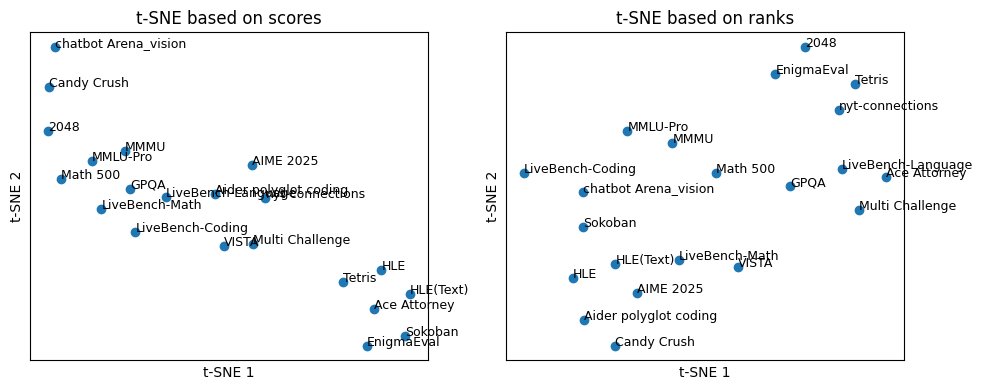

In [12]:
# draw correlation map
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
titles = ["t-SNE based on scores", "t-SNE based on ranks"]

# Convert to numpy array, forcing all values to be float (NaNs for invalid values)
values = np.array([np.array(row, dtype=np.float64) for row in benchmark_data.values()], dtype=np.float64)
keys = list(benchmark_data.keys())  # Start with all keys

# Remove rows with any NaN values
mask = ~np.isnan(values).any(axis=1)
values = values[mask]
keys = [keys[i] for i in range(len(keys)) if mask[i]]  # Only keep keys for valid rows

# Normalize each column (feature-wise) instead of row-wise
min_vals = np.nanmin(values, axis=0, keepdims=True)
max_vals = np.nanmax(values, axis=0, keepdims=True)
range_vals = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
normal_values = (values - min_vals) / range_vals

# Apply t-SNE (reduce to 2D for visualization)
for i in range(2):
    tsne = TSNE(n_components=2, perplexity=7, random_state=0)
    tsne_result = tsne.fit_transform(normal_values if i == 0 else np.apply_along_axis(rankdata, axis=1, arr=normal_values))
    
    ax[i].scatter(tsne_result[:, 0], tsne_result[:, 1])
    for j, key in enumerate(keys):
        ax[i].text(tsne_result[j, 0], tsne_result[j, 1], key, fontsize=9)
    
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("t-SNE 1")
    ax[i].set_ylabel("t-SNE 2")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.savefig('tsne.png', dpi=300, bbox_inches='tight')
plt.show()

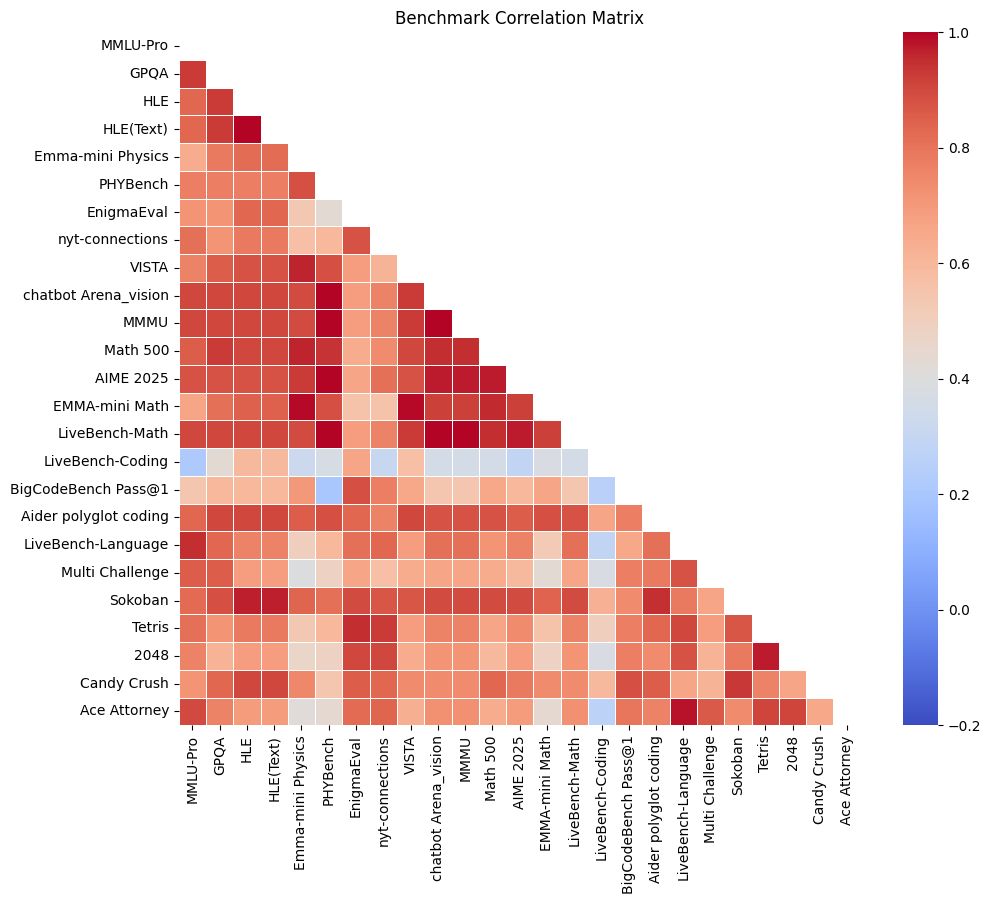

In [13]:
corr_matrix = benchmark_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(11, 9))
sns.heatmap(
    corr_matrix,
    mask=mask,  # apply the mask here
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0.4,
    linewidths=0.5,
    vmin=-0.2,
    vmax=1.0
)
plt.title("Benchmark Correlation Matrix")
plt.show()



False 3.474114723859116
benchmark:
[0.42 0.00 0.15 0.43] MMLU-Pro
[0.46 0.18 0.00 0.36] GPQA
[0.48 0.29 0.15 0.08] HLE
[0.48 0.29 0.15 0.08] HLE(Text)
[0.79 0.21 0.00 0.00] Emma-mini Physics
[0.93 0.00 0.07 0.00] PHYBench
[0.16 0.29 0.46 0.09] EnigmaEval
[0.36 0.00 0.64 0.00] nyt-connections
[0.58 0.29 0.00 0.13] VISTA
[0.69 0.04 0.12 0.16] chatbot Arena_vision
[0.69 0.04 0.12 0.16] MMMU
[0.73 0.13 0.04 0.10] Math 500
[0.76 0.00 0.20 0.04] AIME 2025
[0.77 0.23 0.00 0.00] EMMA-mini Math
[0.69 0.04 0.12 0.16] LiveBench-Math
[0.10 0.75 0.05 0.09] LiveBench-Coding
[0.20 0.39 0.41 0.00] BigCodeBench Pass@1
[0.37 0.31 0.10 0.23] Aider polyglot coding
[0.25 0.00 0.29 0.46] LiveBench-Language
[0.15 0.19 0.00 0.66] Multi Challenge
[0.44 0.27 0.28 0.01] Sokoban
[0.22 0.11 0.51 0.16] Tetris
[0.22 0.03 0.60 0.14] 2048
[0.36 0.35 0.28 0.00] Candy Crush
[0.18 0.00 0.37 0.45] Ace Attorney


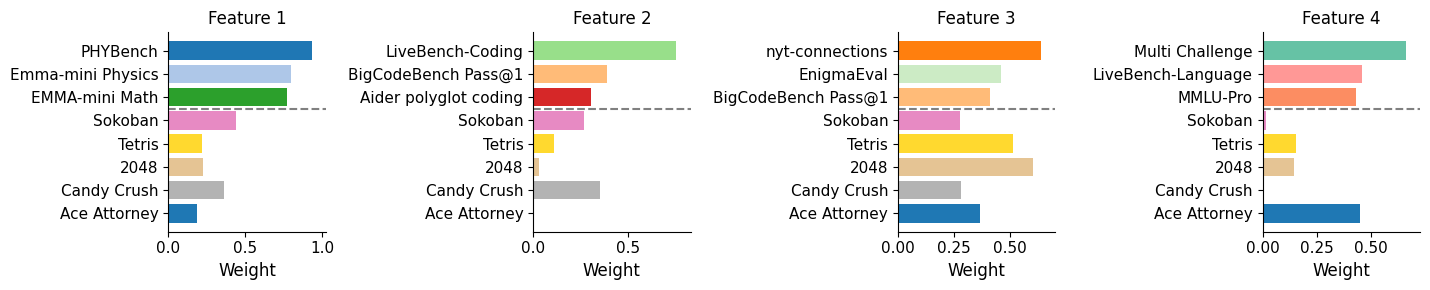

In [14]:

benchmark_ranks = {}
for benchmark, scores in benchmark_data.items():
    scores_array = np.array(scores, dtype=np.float64)
    valid_mask = ~np.isnan(scores_array)
    ranks = np.full_like(scores_array, fill_value=np.nan, dtype=np.float64)
    ranks[valid_mask] = rankdata(scores_array[valid_mask], method='average')
    benchmark_ranks[benchmark] = ranks.tolist()
benchmark_df_rank = pd.DataFrame(benchmark_ranks)
np.random.seed(12)  
feature_num = 4
Y = (benchmark_df_rank*0.2).to_numpy()
bias = False

M_hat, B_hat,  success, loss = factorize_with_scipy_no_bias(Y,feature_num, lambda_l1=0.08, lambda_l2_m=0.01, lambda_l2_b=0.00)
print(success, loss)

np.set_printoptions(suppress=True, precision=2)

normalized = B_hat / B_hat.sum(axis=1, keepdims=True)

print("benchmark:")
if bias:
    for bench, feature, feature_normalized, b in zip(benchmark_df.columns, B_hat, normalized, v):
        formatted = " ".join(f"{x:.2f}" for x in feature)
        formatted_normalized = " ".join(f"{x:.2f}" for x in feature_normalized)
        bias_formatted = f"{b:.2f}"
        print(f"[{formatted}] [{formatted_normalized}] {bias_formatted} {bench}")
else:
    for bench, feature, feature_normalized in zip(benchmark_df.columns, B_hat, normalized):
        formatted = " ".join(f"{x:.2f}" for x in feature)
        formatted_normalized = " ".join(f"{x:.2f}" for x in feature_normalized)
        print(f"[{formatted_normalized}] {bench}")
feature_names = [f"Feature_{i+1}" for i in range(normalized.shape[1])]
bench_names   = list(benchmark_df.columns)

# rows = features, columns = benchmarks
bench_feature_df = pd.DataFrame(
    normalized.T,           # transpose ⇒ shape (5, n_benchmarks)
    index=feature_names,     # 5 feature rows
    columns=bench_names      # one column per benchmark
)
# ------------------------------------------------------------------
# 1)  CONFIG --------------------------------------------------------
# ------------------------------------------------------------------
BASELINE = ['Sokoban', 'Tetris', '2048', 'Candy Crush', 'Ace Attorney']
TOP_K    = 3                     # “highest three” you asked for

# your existing colour dictionary (extend it on‑the‑fly if new labels appear)
model_colors = {
    'Multi Challenge': '#66c2a5', 'MMLU-Pro': '#fc8d62', 'GPQA': '#8da0cb',
    'Sokoban': '#e78ac3', 'SMB': '#a6d854', 'Tetris': '#ffd92f',
    '2048': '#e5c494', 'Candy Crush': '#b3b3b3', 'Ace Attorney': '#1f78b4',
    'NYT-connections': '#fb8072', 'Math 500': '#80b1d3', 'AIME 2025': '#fdb462',
    'MGSM': '#bebada', 'VISTA': '#ffed6f', 'HLE': '#bc80bd',
    'MMMU': '#fccde5', 'EnigmaEval': '#ccebc5'
}

# ------------------------------------------------------------------
# 2)  BUILD LABELS + WEIGHTS FOR EVERY FEATURE ---------------------
# ------------------------------------------------------------------
labels_per_feat  = []
weights_per_feat = []

for feat_name, row in bench_feature_df.iterrows():
    # pick top‑K non‑baseline benchmarks
    top_other = (
        row.drop(BASELINE)      # exclude always‑keep columns
           .sort_values(ascending=False)
           .head(TOP_K)
           .index.tolist()
    )
    ordered_labels = top_other + BASELINE          # preserve the order you used before
    labels_per_feat.append(ordered_labels)
    weights_per_feat.append(row[ordered_labels].values)

# ------------------------------------------------------------------
# 3)  GUARANTEE A COLOUR FOR EVERY LABEL ---------------------------
# ------------------------------------------------------------------
needed = set(chain(*labels_per_feat)) - model_colors.keys()
if needed:                                 # assign any still‑missing labels a palette colour
    extra_palette = sns.color_palette("tab20", len(needed))
    model_colors.update(dict(zip(needed, extra_palette)))

# ------------------------------------------------------------------
# 4)  PLOT ----------------------------------------------------------
# ------------------------------------------------------------------
n_feat = len(labels_per_feat)
fig, axes = plt.subplots(1, n_feat, figsize=(3.6 * n_feat, 3))
plt.subplots_adjust(wspace=0.4)

for i, (ax, labels, weights) in enumerate(zip(axes, labels_per_feat, weights_per_feat)):
    bar_colors = [model_colors[l] for l in labels]
    ax.barh(labels, weights, color=bar_colors)

    ax.set_title(f"Feature {i+1}", fontsize=12)
    ax.set_xlabel("Weight", fontsize=12)
    ax.tick_params(axis='both', labelsize=11)
    ax.set_xlim(0, weights.max() * 1.1)

    ax.invert_yaxis()
    ax.spines[['top', 'right']].set_visible(False)
    # dashed line separating “top‑K” and baseline for quick visual cue
    ax.hlines(y=len(labels) - len(BASELINE) - 0.5,
              xmin=0, xmax=1, colors='gray', linestyles='--',
              transform=ax.get_yaxis_transform())

plt.tight_layout()
plt.savefig("low‑rank_consistent_colours.png", dpi=300, bbox_inches='tight')
plt.show()

Normalizing columns: ['Sokoban', 'Tetris', '2048', 'Candy Crush', 'Ace Attorney']
Generating simple t-SNE plots...
Saved t-SNE plots: tsne.png


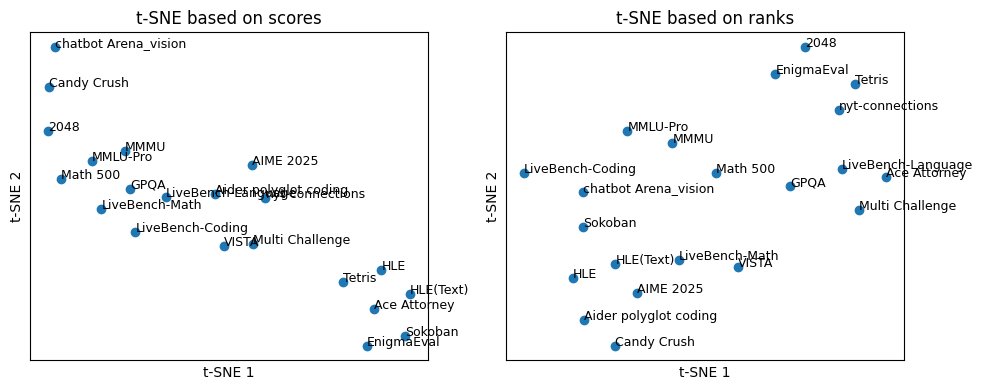

t-SNE visualization complete
Generating simple correlation matrix...
Saved correlation matrix: correlation_matrix.png


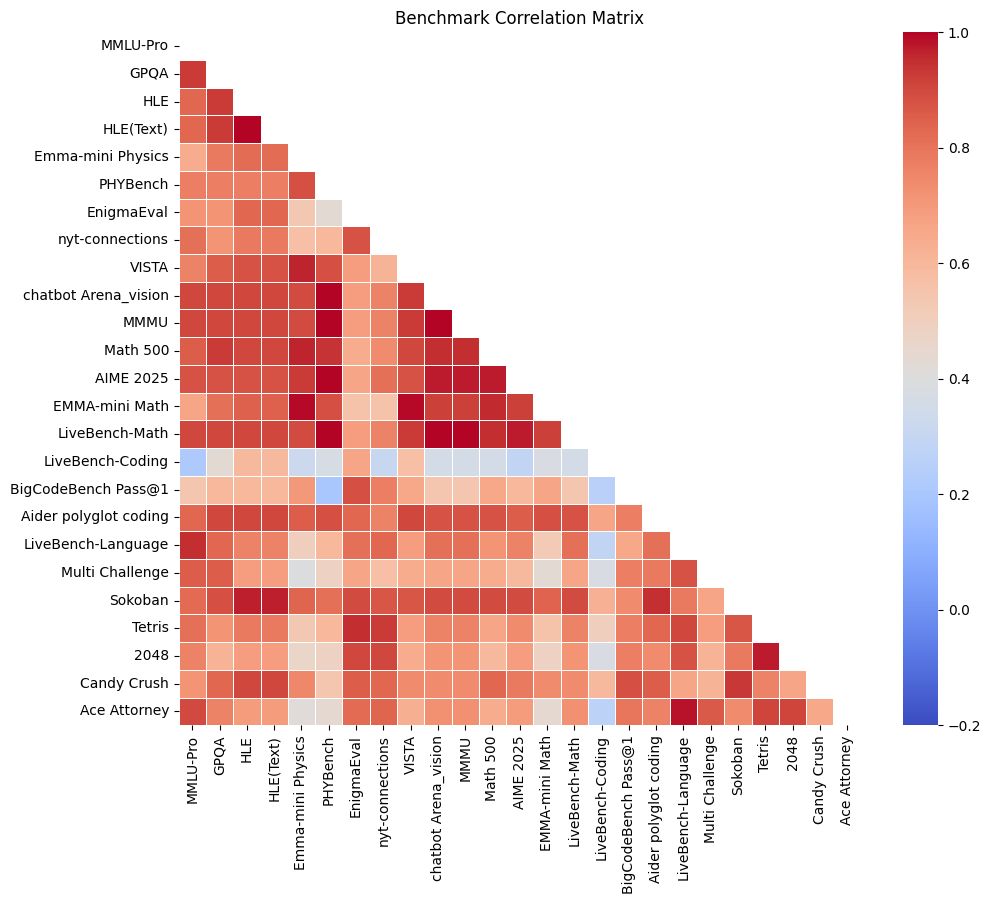

Correlation matrix complete
Generating latent factorization with 4 features...
Factorization: success=False, loss=3.4741
benchmark:
[0.42 0.00 0.15 0.43] MMLU-Pro
[0.46 0.18 0.00 0.36] GPQA
[0.48 0.29 0.15 0.08] HLE
[0.48 0.29 0.15 0.08] HLE(Text)
[0.79 0.21 0.00 0.00] Emma-mini Physics
[0.93 0.00 0.07 0.00] PHYBench
[0.16 0.29 0.46 0.09] EnigmaEval
[0.36 0.00 0.64 0.00] nyt-connections
[0.58 0.29 0.00 0.13] VISTA
[0.69 0.04 0.12 0.16] chatbot Arena_vision
[0.69 0.04 0.12 0.16] MMMU
[0.73 0.13 0.04 0.10] Math 500
[0.76 0.00 0.20 0.04] AIME 2025
[0.77 0.23 0.00 0.00] EMMA-mini Math
[0.69 0.04 0.12 0.16] LiveBench-Math
[0.10 0.75 0.05 0.09] LiveBench-Coding
[0.20 0.39 0.41 0.00] BigCodeBench Pass@1
[0.37 0.31 0.10 0.23] Aider polyglot coding
[0.25 0.00 0.29 0.46] LiveBench-Language
[0.15 0.19 0.00 0.66] Multi Challenge
[0.44 0.27 0.28 0.01] Sokoban
[0.22 0.11 0.51 0.16] Tetris
[0.22 0.03 0.60 0.14] 2048
[0.36 0.35 0.28 0.00] Candy Crush
[0.18 0.00 0.37 0.45] Ace Attorney
Saved latent fac

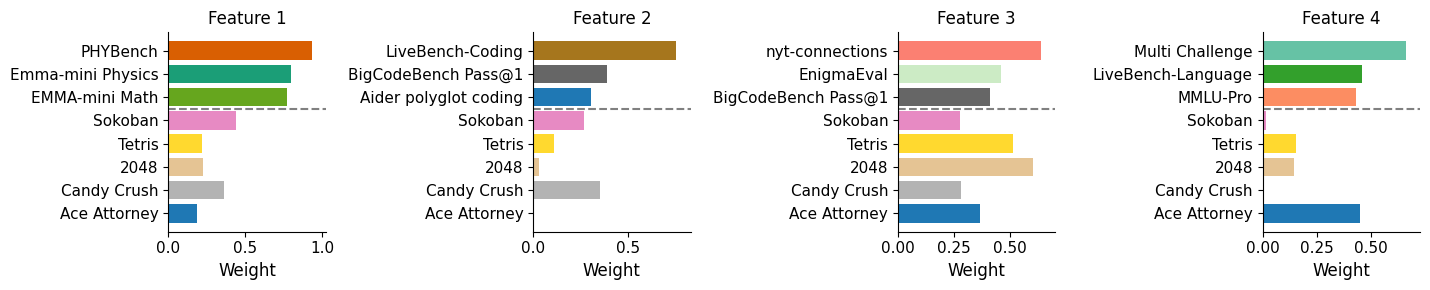

Latent factorization complete


In [15]:
from notebook_utils import *
# Prepare existing other benchmark data
benchmark_data = {
    "MMLU-Pro": [78.4, 82.7, 84.1, 79.4, 69.1, 83.5, 85.6, 80.6],
    "GPQA": [59.1, 75.3, 80.3, 67.7, 53, 73, 83.6, 74.5],
    "HLE": [4.08, 9.04, 17.8, 5.68, 2.72, 7.96, 20.32, 18.08],
    "HLE(Text)": [4.32, 7.89, 18.38, 5.34, 2.32, 7.75, 20.57, 18.9],
    "Emma-mini Physics": [38, 65, 81, None, 44, 49, 76, 77],
    "PHYBench": [None, 15.3, 36.9, None, 7, 18, 34.8, 29.4], 
    "EnigmaEval": [0.91, 4.23, 2.36, 0.58, 0.8, 5.56, 11.91, 9.21], 
    "nyt-connections": [17.7, 33.6, 42.5, 19.1, 25.2, 70.8, 79.5, 68.8], 
    "VISTA": [38.72, 48.23, 54.65, 38.33, 37.99, 45.25, 50.07, 51.79], 
    "chatbot Arena_vision": [1183, 1208, 1379, 1185, 1126, 1231, 1302, 1265], 
    "MMMU": [68.9, 76, 81.5, 72.6, 68.1, 77.7, 80.1, 79.7], 
    "Math 500": [72.4, 91.6, 95.2, 85.2, 74, 90.4, 94.6, 94.2], 
    "AIME 2025": [4.6, 40, 84.2, 17.5, 9.6, 69.6, 83.8, 82.7], 
    "EMMA-mini Math": [30, 45, 60, None, 30, 41, 48, 56],
    "LiveBench-Math": [50.54, 79, 88.63, 60.58, 41.48, 79.28, 85, 84.9], 
    "LiveBench-Coding": [73.9, 73.19, 72.87, 54.19, 69.29, 57.14, 76.71, 79.98], 
    "BigCodeBench Pass@1": [30.4, 35.8, 33.1, 28.4, 31.1, 35.5, None, None], 
    "Aider polyglot coding": [51.6, 64.9, 76.9, 15.6, 18.2, 61.7, 79.6, 72], 
    "LiveBench-Language": [54.48, 68.27, 71.81, 49.65, 44.68, 72.15, 76, 66.05],
    "Multi Challenge": [43.2, 51.58, 49.91, 32.06, 27.81, 44.93, 56.51, 42.99],
    "Sokoban": [0, 2.3, 4.3, 0, 0, 2.3, 8, 5.3],
    "Tetris": [14.7, 16.3, 23.3, 10.3, 14, 35, 43, 25.3],
    "2048": [108.2, 113.3, 117.3, 106.0, 106.7, 128.9, 128, 120.6],
    "Candy Crush": [106.0, 484, 416.3, 128.7, 147.3, 159, 647, 487.3],
    "Ace Attorney": [2, 7, 7, 0, 0, 16, 16, 4]
}

model_names = ["claude-3-5-sonnet-20241022", "claude-3-7-sonnet-20250219", 
               "gemini-2.5-pro-preview-05-06", "llama-4-maverick-17b-128e-instruct-fp8",
               "gpt-4o-2024-11-20", "o1-2024-12-17", "o3-2025-04-16", "o4-mini-2025-04-16"]

# Step 1: Create DataFrame
benchmark_df = pd.DataFrame(benchmark_data).reset_index(drop=True)

# Step 2: Normalize game columns  
columns_to_normalize = ["Sokoban", "Tetris", "2048", "Candy Crush", "Ace Attorney"]
normalized_benchmark_df = normalize_game_columns(benchmark_df, columns_to_normalize)

# Step 3: Generate all plots
generate_simple_tsne_plots(benchmark_data, save_plot=True)
generate_simple_correlation_matrix(normalized_benchmark_df, save_plot=True)
factorization_results = generate_simple_latent_factorization(
    benchmark_data, normalized_benchmark_df, feature_num=4, save_plot=True
)

In [16]:
updated_benchmark_df

,MMLU-Pro,GPQA,HLE,HLE(Text),Emma-mini Physics,PHYBench,EnigmaEval,nyt-connections,VISTA,chatbot Arena_vision,...,LiveBench-Coding,BigCodeBench Pass@1,Aider polyglot coding,LiveBench-Language,Multi Challenge,Sokoban,Tetris,2048,Candy Crush,Ace Attorney
0,78.4,59.1,4.08,4.32,38.0,NaN,0.91,17.7,38.72,1183,...,73.90,30.4,51.6,54.48,43.20,1.0000,14.321101,10.510917,1.000000,13.3750
1,82.7,75.3,9.04,7.89,65.0,15.3,4.23,33.6,48.23,1208,...,73.19,35.8,64.9,68.27,51.58,29.4625,19.165138,32.558952,70.171904,44.3125
2,84.1,80.3,17.80,18.38,81.0,36.9,2.36,42.5,54.65,1379,...,72.87,33.1,76.9,71.81,49.91,54.2125,40.357798,49.851528,57.783179,44.3125
3,79.4,67.7,5.68,5.34,NaN,NaN,0.58,19.1,38.33,1185,...,54.19,28.4,15.6,49.65,32.06,1.0000,1.000000,1.000000,5.153974,1.0000
4,69.1,53.0,2.72,2.32,44.0,7.0,0.80,25.2,37.99,1126,...,69.29,31.1,18.2,44.68,27.81,1.0000,12.201835,4.026201,8.557671,1.0000
5,83.5,73.0,7.96,7.75,49.0,18.0,5.56,70.8,45.25,1231,...,57.14,35.5,61.7,72.15,44.93,29.4625,75.779817,100.000000,10.698706,100.0000
6,85.6,83.6,20.32,20.57,76.0,34.8,11.91,79.5,50.07,1302,...,76.71,NaN,79.6,76.00,56.51,100.0000,100.000000,96.109170,100.000000,100.0000
7,80.6,74.5,18.08,18.90,77.0,29.4,9.21,68.8,51.79,1265,...,79.98,NaN,72.0,66.05,42.99,66.5875,46.412844,64.117904,70.775786,25.7500


In [17]:
import numpy as np
import cvxpy as cp
from scipy.optimize import minimize, LinearConstraint


def factorize_with_scipy_no_bias(Y, d, lambda_l1=0.01, lambda_l2_m=0.01, lambda_l2_b=0.01):
    T, S = Y.shape

    def unpack(x):
        M = x[:T*d].reshape(T, d)
        B = x[T*d:T*d + S*d].reshape(S, d)
        return M, B

    def loss_fn(x):
        M, B = unpack(x)
        Y_hat = M @ B.T # change this line to handle null values in Y, so for positions if nan values in Y, don't need to compute the Y_hat
            
        mask = ~np.isnan(Y)
        
        loss = np.sum((Y[mask] - Y_hat[mask])**2)
        l1 = lambda_l1 * np.sum(np.abs(B))
        l2 = lambda_l2_m * np.sum(M**2) + lambda_l2_b * np.sum(B**2) 
        
        # Soft constraint loss: encourage M[2, k] <= M[3, k] for all k
        # soft_constraint = np.sum(np.maximum(M[2] - M[3], 0.0)**2)
        # pairwise = lambda_pair * soft_constraint

        return loss + l1 + l2

    x0 = np.random.rand((T + S) * d)
    
    bounds = [(0, None)] * len(x0)
    res = minimize(loss_fn, x0, bounds=bounds, method='L-BFGS-B', options={
        'maxfun': 50000,     # maximum number of function evaluations
        'maxiter': 50000,    # maximum number of iterations
        'disp': True        # optional: print progress
    })
    success, loss = res.success, res.fun

    M_opt, B_opt = unpack(res.x)
    return M_opt, B_opt, success, loss

def factorize_with_scipy_bias(Y, d, lambda_l1=0.01, lambda_l2_m=0.01, lambda_l2_b=0.01):
    T, S = Y.shape

    def unpack(x):
        M = x[:T*d].reshape(T, d)
        B = x[T*d:T*d + S*d].reshape(S, d)
        v = x[T*d + S*d:].reshape(S)  # Benchmark bias
        return M, B, v
    
    def loss_fn(x):
        M, B, v = unpack(x)
        Y_hat = M @ B.T + v[None, :]  # Add benchmark bias
        
        mask = ~np.isnan(Y)

        loss = np.sum((Y[mask] - Y_hat[mask])**2)
        l1 = lambda_l1 * np.sum(np.abs(B))
        l2 = lambda_l2_m * np.sum(M**2) + lambda_l2_b * np.sum(B**2) 
        
        return loss + l1 + l2

    # Initial values
    x0 = np.random.rand((T + S) * d + S)
    
    bounds = [(0, None)] * len(x0)
    res = minimize(loss_fn, x0, bounds=bounds, method='L-BFGS-B',options={
        'maxfun': 50000,     # maximum number of function evaluations
        'maxiter': 50000,    # maximum number of iterations
        'disp': True        # optional: print progress
    })
    success, loss = res.success, res.fun

    M_opt, B_opt, v_opt = unpack(res.x)
    return M_opt, B_opt, v_opt, success, loss

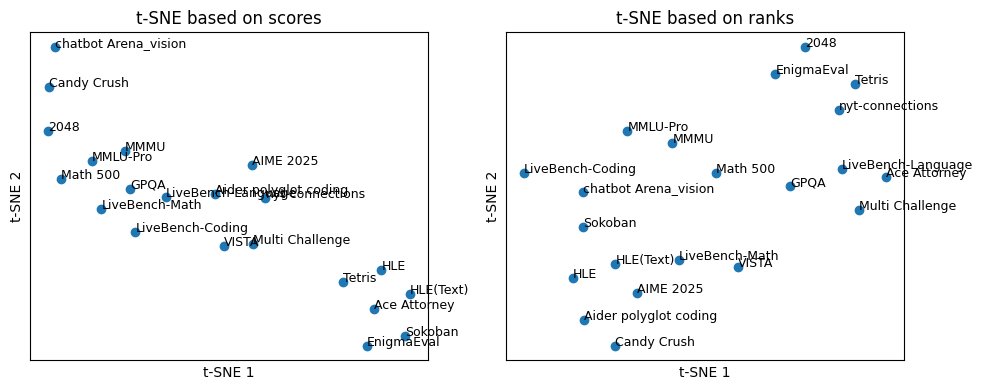

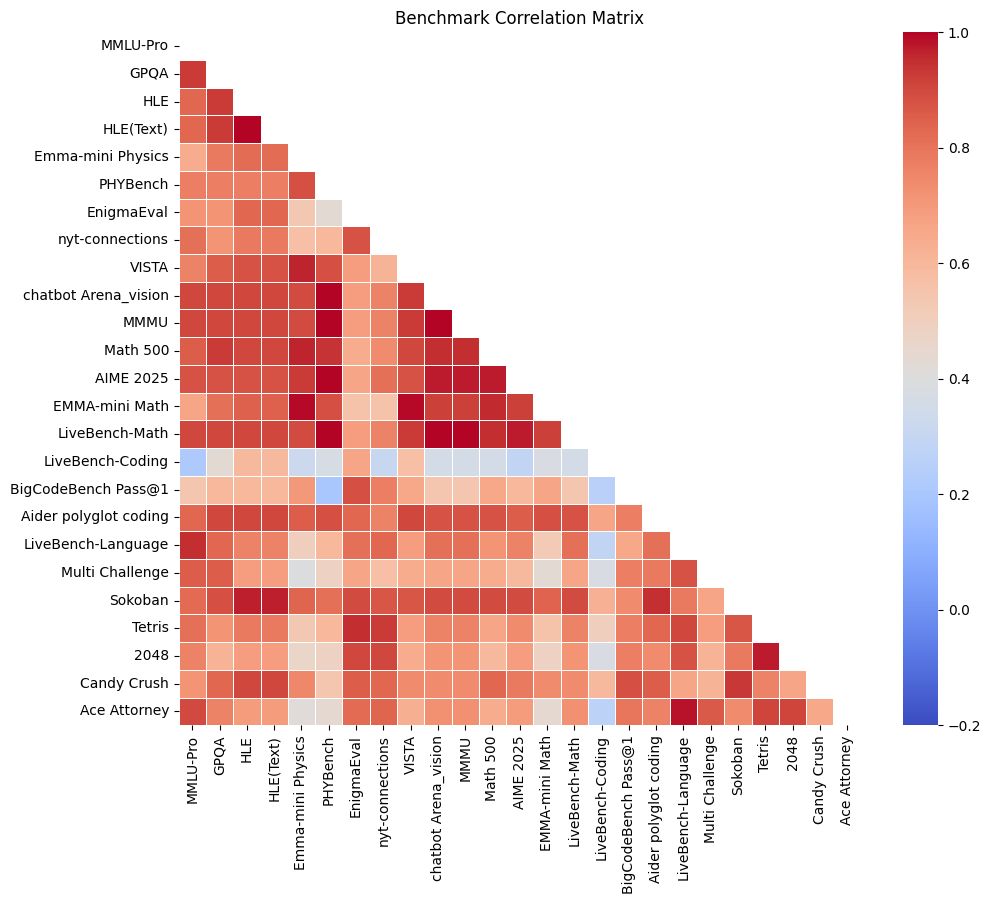

False 3.474114723859116
benchmark:
[0.42 0.00 0.15 0.43] MMLU-Pro
[0.46 0.18 0.00 0.36] GPQA
[0.48 0.29 0.15 0.08] HLE
[0.48 0.29 0.15 0.08] HLE(Text)
[0.79 0.21 0.00 0.00] Emma-mini Physics
[0.93 0.00 0.07 0.00] PHYBench
[0.16 0.29 0.46 0.09] EnigmaEval
[0.36 0.00 0.64 0.00] nyt-connections
[0.58 0.29 0.00 0.13] VISTA
[0.69 0.04 0.12 0.16] chatbot Arena_vision
[0.69 0.04 0.12 0.16] MMMU
[0.73 0.13 0.04 0.10] Math 500
[0.76 0.00 0.20 0.04] AIME 2025
[0.77 0.23 0.00 0.00] EMMA-mini Math
[0.69 0.04 0.12 0.16] LiveBench-Math
[0.10 0.75 0.05 0.09] LiveBench-Coding
[0.20 0.39 0.41 0.00] BigCodeBench Pass@1
[0.37 0.31 0.10 0.23] Aider polyglot coding
[0.25 0.00 0.29 0.46] LiveBench-Language
[0.15 0.19 0.00 0.66] Multi Challenge
[0.44 0.27 0.28 0.01] Sokoban
[0.22 0.11 0.51 0.16] Tetris
[0.22 0.03 0.60 0.14] 2048
[0.36 0.35 0.28 0.00] Candy Crush
[0.18 0.00 0.37 0.45] Ace Attorney


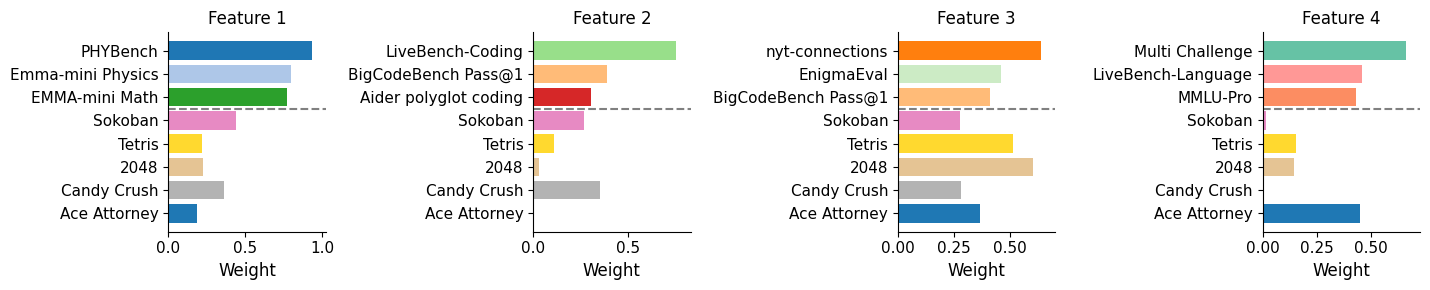

In [18]:
benchmark_data = {
    "MMLU-Pro": [78.4, 82.7, 84.1, 79.4, 69.1, 83.5, 85.6, 80.6],
    "GPQA": [59.1, 75.3, 80.3, 67.7, 53, 73, 83.6, 74.5],
    "HLE": [4.08, 9.04, 17.8, 5.68, 2.72, 7.96, 20.32, 18.08],
    "HLE(Text)": [4.32, 7.89, 18.38, 5.34, 2.32, 7.75, 20.57, 18.9],
    "Emma-mini Physics": [38, 65, 81, None, 44, 49, 76, 77],
    "PHYBench": [None, 15.3, 36.9, None, 7, 18, 34.8, 29.4], 
    "EnigmaEval": [0.91, 4.23, 2.36, 0.58, 0.8, 5.56, 11.91, 9.21], 
    "nyt-connections": [17.7, 33.6, 42.5, 19.1, 25.2, 70.8, 79.5, 68.8], 
    "VISTA": [38.72, 48.23, 54.65, 38.33, 37.99, 45.25, 50.07, 51.79], 
    "chatbot Arena_vision": [1183, 1208, 1379, 1185, 1126, 1231, 1302, 1265], 
    "MMMU": [68.9, 76, 81.5, 72.6, 68.1, 77.7, 80.1, 79.7], 
    "Math 500": [72.4, 91.6, 95.2, 85.2, 74, 90.4, 94.6, 94.2], 
    "AIME 2025": [4.6, 40, 84.2, 17.5, 9.6, 69.6, 83.8, 82.7], 
    "EMMA-mini Math": [30, 45, 60, None, 30, 41, 48, 56],
    "LiveBench-Math": [50.54, 79, 88.63, 60.58, 41.48, 79.28, 85, 84.9], 
    "LiveBench-Coding": [73.9, 73.19, 72.87, 54.19, 69.29, 57.14, 76.71, 79.98], 
    "BigCodeBench Pass@1": [30.4, 35.8, 33.1, 28.4, 31.1, 35.5, None, None], 
    "Aider polyglot coding": [51.6, 64.9, 76.9, 15.6, 18.2, 61.7, 79.6, 72], 
    "LiveBench-Language": [54.48, 68.27, 71.81, 49.65, 44.68, 72.15, 76, 66.05],
    "Multi Challenge": [43.2, 51.58, 49.91, 32.06, 27.81, 44.93, 56.51, 42.99],
    "Sokoban": [0, 2.3, 4.3, 0, 0, 2.3, 8, 5.3],
    # "SMB": [1267.7, 1418.7, 1498.3, 1468.7, 2047.3, 855, 3445, 1448],
    "Tetris": [14.7, 16.3, 23.3, 10.3, 14, 35, 43, 25.3],
    "2048": [108.2, 113.3, 117.3, 106.0, 106.7, 128.9, 128, 120.6],
    "Candy Crush": [106.0, 484, 416.3, 128.7, 147.3, 159, 647, 487.3],
    "Ace Attorney": [2, 7, 7, 0, 0, 16, 16, 4]
}
benchmark_df = pd.DataFrame(benchmark_data).reset_index(drop=True)

columns_to_normalize = ["Sokoban", "Tetris", "2048", "Candy Crush", "Ace Attorney"]

# Normalizing only the specified columns
benchmark_df[columns_to_normalize] = benchmark_df[columns_to_normalize].apply(
    lambda x: (x - x.min()) / (x.max() - x.min()) * 99 + 1
)


fig, ax = plt.subplots(1, 2, figsize=(10, 4))
titles = ["t-SNE based on scores", "t-SNE based on ranks"]

# Convert to numpy array, forcing all values to be float (NaNs for invalid values)
values = np.array([np.array(row, dtype=np.float64) for row in benchmark_data.values()], dtype=np.float64)
keys = list(benchmark_data.keys())  # Start with all keys

# Remove rows with any NaN values
mask = ~np.isnan(values).any(axis=1)
values = values[mask]
keys = [keys[i] for i in range(len(keys)) if mask[i]]  # Only keep keys for valid rows

# Normalize each column (feature-wise) instead of row-wise
min_vals = np.nanmin(values, axis=0, keepdims=True)
max_vals = np.nanmax(values, axis=0, keepdims=True)
range_vals = np.where(max_vals - min_vals == 0, 1, max_vals - min_vals)
normal_values = (values - min_vals) / range_vals

# Apply t-SNE (reduce to 2D for visualization)
for i in range(2):
    tsne = TSNE(n_components=2, perplexity=7, random_state=0)
    tsne_result = tsne.fit_transform(normal_values if i == 0 else np.apply_along_axis(rankdata, axis=1, arr=normal_values))
    
    ax[i].scatter(tsne_result[:, 0], tsne_result[:, 1])
    for j, key in enumerate(keys):
        ax[i].text(tsne_result[j, 0], tsne_result[j, 1], key, fontsize=9)
    
    ax[i].set_title(titles[i])
    ax[i].set_xlabel("t-SNE 1")
    ax[i].set_ylabel("t-SNE 2")
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.tight_layout()
plt.savefig('tsne.png', dpi=300, bbox_inches='tight')
plt.show()


corr_matrix = benchmark_df.corr(method='spearman')
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
plt.figure(figsize=(11, 9))
sns.heatmap(
    corr_matrix,
    mask=mask,  # apply the mask here
    annot=False,
    fmt=".2f",
    cmap="coolwarm",
    center=0.4,
    linewidths=0.5,
    vmin=-0.2,
    vmax=1.0
)
plt.title("Benchmark Correlation Matrix")
plt.show()


benchmark_ranks = {}
for benchmark, scores in benchmark_data.items():
    scores_array = np.array(scores, dtype=np.float64)
    valid_mask = ~np.isnan(scores_array)
    ranks = np.full_like(scores_array, fill_value=np.nan, dtype=np.float64)
    ranks[valid_mask] = rankdata(scores_array[valid_mask], method='average')
    benchmark_ranks[benchmark] = ranks.tolist()
benchmark_df_rank = pd.DataFrame(benchmark_ranks)
np.random.seed(12)  
feature_num = 4
Y = (benchmark_df_rank*0.2).to_numpy()
bias = False

M_hat, B_hat,  success, loss = factorize_with_scipy_no_bias(Y,feature_num, lambda_l1=0.08, lambda_l2_m=0.01, lambda_l2_b=0.00)
print(success, loss)

np.set_printoptions(suppress=True, precision=2)

normalized = B_hat / B_hat.sum(axis=1, keepdims=True)

print("benchmark:")
if bias:
    for bench, feature, feature_normalized, b in zip(benchmark_df.columns, B_hat, normalized, v):
        formatted = " ".join(f"{x:.2f}" for x in feature)
        formatted_normalized = " ".join(f"{x:.2f}" for x in feature_normalized)
        bias_formatted = f"{b:.2f}"
        print(f"[{formatted}] [{formatted_normalized}] {bias_formatted} {bench}")
else:
    for bench, feature, feature_normalized in zip(benchmark_df.columns, B_hat, normalized):
        formatted = " ".join(f"{x:.2f}" for x in feature)
        formatted_normalized = " ".join(f"{x:.2f}" for x in feature_normalized)
        print(f"[{formatted_normalized}] {bench}")
feature_names = [f"Feature_{i+1}" for i in range(normalized.shape[1])]
bench_names   = list(benchmark_df.columns)

# rows = features, columns = benchmarks
bench_feature_df = pd.DataFrame(
    normalized.T,           # transpose ⇒ shape (5, n_benchmarks)
    index=feature_names,     # 5 feature rows
    columns=bench_names      # one column per benchmark
)
# ------------------------------------------------------------------
# 1)  CONFIG --------------------------------------------------------
# ------------------------------------------------------------------
BASELINE = ['Sokoban', 'Tetris', '2048', 'Candy Crush', 'Ace Attorney']
TOP_K    = 3                     # “highest three” you asked for

# your existing colour dictionary (extend it on‑the‑fly if new labels appear)
model_colors = {
    'Multi Challenge': '#66c2a5', 'MMLU-Pro': '#fc8d62', 'GPQA': '#8da0cb',
    'Sokoban': '#e78ac3', 'SMB': '#a6d854', 'Tetris': '#ffd92f',
    '2048': '#e5c494', 'Candy Crush': '#b3b3b3', 'Ace Attorney': '#1f78b4',
    'NYT-connections': '#fb8072', 'Math 500': '#80b1d3', 'AIME 2025': '#fdb462',
    'MGSM': '#bebada', 'VISTA': '#ffed6f', 'HLE': '#bc80bd',
    'MMMU': '#fccde5', 'EnigmaEval': '#ccebc5'
}

# ------------------------------------------------------------------
# 2)  BUILD LABELS + WEIGHTS FOR EVERY FEATURE ---------------------
# ------------------------------------------------------------------
labels_per_feat  = []
weights_per_feat = []

for feat_name, row in bench_feature_df.iterrows():
    # pick top‑K non‑baseline benchmarks
    top_other = (
        row.drop(BASELINE)      # exclude always‑keep columns
           .sort_values(ascending=False)
           .head(TOP_K)
           .index.tolist()
    )
    ordered_labels = top_other + BASELINE          # preserve the order you used before
    labels_per_feat.append(ordered_labels)
    weights_per_feat.append(row[ordered_labels].values)

# ------------------------------------------------------------------
# 3)  GUARANTEE A COLOUR FOR EVERY LABEL ---------------------------
# ------------------------------------------------------------------
needed = set(chain(*labels_per_feat)) - model_colors.keys()
if needed:                                 # assign any still‑missing labels a palette colour
    extra_palette = sns.color_palette("tab20", len(needed))
    model_colors.update(dict(zip(needed, extra_palette)))

# ------------------------------------------------------------------
# 4)  PLOT ----------------------------------------------------------
# ------------------------------------------------------------------
n_feat = len(labels_per_feat)
fig, axes = plt.subplots(1, n_feat, figsize=(3.6 * n_feat, 3))
plt.subplots_adjust(wspace=0.4)

for i, (ax, labels, weights) in enumerate(zip(axes, labels_per_feat, weights_per_feat)):
    bar_colors = [model_colors[l] for l in labels]
    ax.barh(labels, weights, color=bar_colors)

    ax.set_title(f"Feature {i+1}", fontsize=12)
    ax.set_xlabel("Weight", fontsize=12)
    ax.tick_params(axis='both', labelsize=11)
    ax.set_xlim(0, weights.max() * 1.1)

    ax.invert_yaxis()
    ax.spines[['top', 'right']].set_visible(False)
    # dashed line separating “top‑K” and baseline for quick visual cue
    ax.hlines(y=len(labels) - len(BASELINE) - 0.5,
              xmin=0, xmax=1, colors='gray', linestyles='--',
              transform=ax.get_yaxis_transform())

plt.tight_layout()
plt.savefig("low‑rank_consistent_colours.png", dpi=300, bbox_inches='tight')
plt.show()